# State Farm Distracted Driver Detection

In [19]:
# %pip install ultralytics
# %pip install split-folders
# %pip install -U ipywidgets


In [176]:
import csv
import os
from glob import glob
from shutil import copyfile
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, BatchNormalization, Dropout
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.vgg16 import VGG16
from ultralytics import YOLO
import splitfolders
import pandas as pd
import numpy as np
from IPython.display import display, Image
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

%matplotlib inline

## Loading the data

In [21]:
data = {}

with open('../datasets/state-farm-distracted-driver-detection/driver_imgs_list.csv') as file:
    read_file = csv.reader(file)
    read_file = list(read_file)
    
    for row in read_file[1:]:
        key = row[1]
        if key in data:
            data[key].append(row[2])
        else:
            data[key] = [row[2]]

In [22]:
data['c0'][:5]

['img_44733.jpg',
 'img_72999.jpg',
 'img_25094.jpg',
 'img_69092.jpg',
 'img_92629.jpg']

In [23]:
classes_list = list(data.keys())
classes_list

['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9']

In [24]:
dataset_folder = '../datasets/state-farm-distracted-driver-detection/imgs/'

train_dir = os.path.join(dataset_folder, 'train/')
test_dir = os.path.join(dataset_folder, 'test/')

In [25]:
print('Number of images in the training dataset : ', str(len(glob(train_dir+'*/*'))))
print('Number of images in the testing dataset : ', str(len(glob(test_dir+'*'))))

Number of images in the training dataset :  22424
Number of images in the testing dataset :  79726


In [ ]:
# Need to separate the training set and the validation set.

### Writing helper function for creating directories for training set, validation set and test set

In [26]:
def remove_directory(path):
    for root, dirs, files in os.walk(path, topdown = False):
        for name in files:
            file_path = os.path.join(root, name)
            os.remove(file_path)
        for name in dirs:
            dir_path = os.path.join(root, name)
            os.rmdir(dir_path)
    os.rmdir(path)

In [27]:
def create_directories(paths, subfolders):
    for path in paths:
        if os.path.exists(path):
            remove_directory(path)
        
        for folder in subfolders:
            subfolder_path = os.path.join(path, folder)
            os.makedirs(subfolder_path)

In [28]:
paths = ['../datasets/state-farm-distracted-driver-detection/cleaned_dataset/train',
         '../datasets/state-farm-distracted-driver-detection/cleaned_dataset/val',
        '../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test']

In [29]:
subfolders = classes_list

### Creating Train, Val, Test folders along with sub-directories (all Classes)

In [31]:
create_directories(paths, subfolders)

### Creating the cleaned dataset using the above helper functions we have created

In [32]:
split_size = [0.6, 0.2]


for clas, images in data.items():
    # print(len(images))
    train_size = int(split_size[0]*len(images))
    # print("Train size: ", train_size)
    
    test_size = int(split_size[1]*len(images))
    #print("Test size: ", test_size)
    
    train_images = images[:train_size]
    # print("Train Images Length", len(train_images))
    
    val_images = images[train_size: train_size + test_size]
    # print("Val Images Length", len(val_images))
    
    test_images = images[train_size + test_size:]
    # print("Test Images Length", len(test_images))
    
    
    
    for image in train_images:
        source = os.path.join(train_dir, clas, image)
        # print(os.path.exists(source))
        dest = os.path.join(paths[0], clas, image)
        copyfile(source, dest)
    
    for image in val_images:
        source = os.path.join(train_dir, clas, image)
        dest = os.path.join(paths[1], clas, image)
        copyfile(source, dest)
    
    for image in test_images:
        source = os.path.join(train_dir, clas, image)
        dest = os.path.join(paths[2], clas, image)
        copyfile(source, dest)
    
    


### Using a better approach for creating the cleaned dataset using `splitfolders` module

### First deleting the cleaned dataset created usinfg the above method

In [33]:
remove_directory('../datasets/state-farm-distracted-driver-detection/cleaned_dataset')

### Creating the cleaned dataset now using splitfolder module

In [34]:
images_dir = '../datasets/state-farm-distracted-driver-detection/imgs/train'
output_folder = '../datasets/state-farm-distracted-driver-detection/cleaned_dataset' # Note: the function will create val, train, test sub directories by itself
split_ratio = (0.6, 0.2, 0.2)



splitfolders.ratio(images_dir, output= output_folder, seed = 10, ratio= split_ratio)

Copying files: 22424 files [00:03, 5949.75 files/s]


Done ! Just needed one line of code.

### From now, we will be using these Directory paths for our training, validation and testing purpose

In [99]:
parent_dir = '../datasets/state-farm-distracted-driver-detection/cleaned_dataset'
train_dir = '../datasets/state-farm-distracted-driver-detection/cleaned_dataset/train'
val_dir = '../datasets/state-farm-distracted-driver-detection/cleaned_dataset/val'
test_dir = '../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test'

## Creating Image data generator Function with Data Augmentation

In [53]:
def imagedatageneration(train_dir, val_dir, test_dir, target_size = (256, 256), batch_size = 32):
    train_datagen = ImageDataGenerator(rescale = 1.0 / 255,
                                       rotation_range = 30,
                                       width_shift_range = 0.1,
                                       height_shift_range = 0.1,
                                       zoom_range = 0.1,
                                       shear_range = 0.1,
                                       fill_mode = "nearest"
                                      )
    train_generator = train_datagen.flow_from_directory(
                                                            train_dir,
                                                            target_size = target_size,
                                                            class_mode = 'categorical',
                                                            shuffle = True,
                                                            batch_size = batch_size
                                                        )
    
    
    val_datagen = ImageDataGenerator(rescale = 1.0 / 255,
                                     rotation_range = 30,
                                     width_shift_range = 0.1,
                                     height_shift_range = 0.1,
                                     zoom_range = 0.1,
                                     shear_range = 0.1,
                                     fill_mode = "nearest"
                                    )
    val_generator = val_datagen.flow_from_directory(
                                                        val_dir,
                                                        target_size = target_size,
                                                        class_mode = 'categorical',
                                                        shuffle = True,
                                                        batch_size = batch_size
                                                    )
    
    test_datagen = ImageDataGenerator(rescale = 1.0/255)
    
    test_generator = test_datagen.flow_from_directory(
                                                        test_dir,
                                                        target_size = target_size,
                                                        class_mode = 'categorical',
                                                        shuffle = False,
                                                        batch_size = 1
                                                      )
    
    return train_generator, val_generator, test_generator
    

In [136]:
es = EarlyStopping(monitor = "val_loss",
                  mode = "min",
                  patience = 5,
                  restore_best_weights = True)
# es = EarlyStopping(monitor = 'val_acc', patience = 2, min_delta = 0.01)

In [186]:
def train_val_plot(model, model_name):
#     dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])
    train_loss, train_acc, val_loss, val_acc = model.history['loss'], model.history['acc'], model.history['val_loss'], model.history['val_acc']
    
    plt.plot(train_acc)
    plt.plot(val_acc)
    plt.title('{} Model Accuracy'.format(model_name))
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc = 'upper left')
    plt.show()
    
    
    plt.plot(train_loss)
    plt.plot(val_loss)
    plt.title('{} Model Loss'.format(model_name))
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc = 'upper left')
    plt.show()
    
    
    

## First Model -> Dense Model

In [144]:
train_generator, val_generator, test_generator = imagedatageneration(train_dir, val_dir, test_dir)

Found 13451 images belonging to 10 classes.
Found 4481 images belonging to 10 classes.
Found 4492 images belonging to 10 classes.


In [138]:
model1 = tf.keras.models.Sequential([
    Flatten(input_shape = (256, 256, 3)),
    Dense(1024, activation = 'relu'),
    BatchNormalization(),
    Dense(512, activation = 'relu'),
    BatchNormalization(),
    Dense(256, activation = 'relu'),
    BatchNormalization(),
    Dense(10, activation = 'softmax')
])

In [139]:
model1.compile(optimizer = Adam(learning_rate = 0.001), loss = 'categorical_crossentropy', metrics = ['acc'])

In [140]:
model1.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_7 (Flatten)         (None, 196608)            0         
                                                                 
 dense_29 (Dense)            (None, 1024)              201327616 
                                                                 
 batch_normalization_23 (Ba  (None, 1024)              4096      
 tchNormalization)                                               
                                                                 
 dense_30 (Dense)            (None, 512)               524800    
                                                                 
 batch_normalization_24 (Ba  (None, 512)               2048      
 tchNormalization)                                               
                                                                 
 dense_31 (Dense)            (None, 256)              

In [141]:
model1_history = model1.fit(train_generator,
                   epochs = 20,
                   verbose = 1,
                   validation_data = val_generator,
                   callbacks = [es])

Epoch 1/20
421/421 [==============================] - 143s 338ms/step - loss: 2.2471 - acc: 0.2038 - val_loss: 2.2135 - val_acc: 0.2397
Epoch 2/20
421/421 [==============================] - 140s 333ms/step - loss: 1.9363 - acc: 0.3006 - val_loss: 1.7974 - val_acc: 0.3347
Epoch 3/20
421/421 [==============================] - 260s 617ms/step - loss: 1.7658 - acc: 0.3577 - val_loss: 1.7637 - val_acc: 0.3696
Epoch 4/20
421/421 [==============================] - 139s 330ms/step - loss: 1.6544 - acc: 0.3980 - val_loss: 1.6520 - val_acc: 0.4086
Epoch 5/20
421/421 [==============================] - 140s 333ms/step - loss: 1.5525 - acc: 0.4432 - val_loss: 1.6011 - val_acc: 0.4492
Epoch 6/20
421/421 [==============================] - 140s 332ms/step - loss: 1.4586 - acc: 0.4720 - val_loss: 1.5316 - val_acc: 0.4615
Epoch 7/20
421/421 [==============================] - 139s 331ms/step - loss: 1.3716 - acc: 0.5090 - val_loss: 1.6137 - val_acc: 0.4414
Epoch 8/20
421/421 [============================

In [145]:
model1_accuracy = model1.evaluate(test_generator)

print("Accuracy based on simple Dense Model :- {:.2f}%".format(model1_accuracy[1]*100))

4492/4492 [==============================] - 186s 41ms/step - loss: 0.7074 - acc: 0.7518
Accuracy based on simple Dense Model :- 75.18%


In [152]:
model1_history.history.keys()

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])

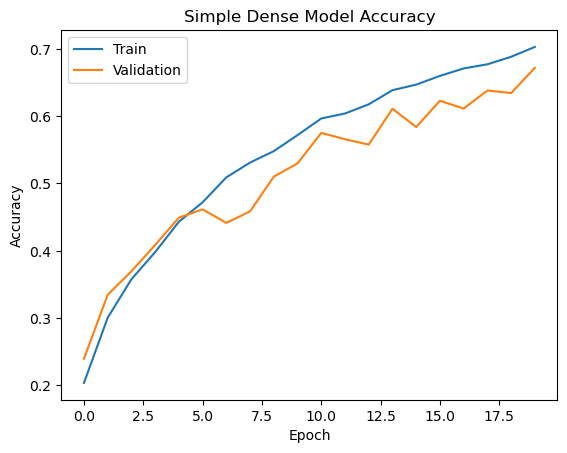

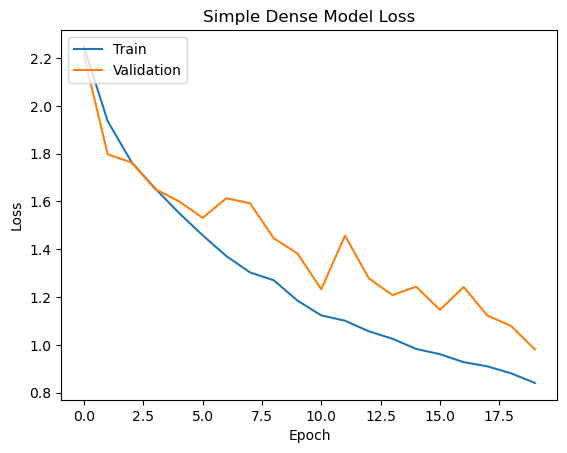

In [187]:
train_val_plot(model1_history, 'Simple Dense')



<Figure size 640x480 with 1 Axes>

<Figure size 640x480 with 1 Axes>

## Second Model -> CNN Model

In [171]:
train_generator, val_generator, test_generator = imagedatageneration(train_dir, val_dir, test_dir)

Found 13451 images belonging to 10 classes.
Found 4481 images belonging to 10 classes.
Found 4492 images belonging to 10 classes.


In [172]:
model2 = tf.keras.models.Sequential([
    Conv2D(32, (3, 3), activation = 'relu', input_shape = (256, 256, 3)),
    Conv2D(32, (3, 3), activation = 'relu'),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation = 'relu'),
    Conv2D(64, (3, 3), activation = 'relu'),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    Conv2D(128, (3, 3), activation = 'relu'),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    Conv2D(128, (3, 3), activation = 'relu'),
    BatchNormalization(),
    Flatten(),
    Dense(512, activation = 'relu'),
    BatchNormalization(),
    Dense(256, activation = 'relu'),
    BatchNormalization(),
    Dense(256, activation = 'relu'),
    BatchNormalization(),
    Dense(128, activation = 'relu'),
    BatchNormalization(),
    Dense(10, activation = 'softmax')
])

In [173]:
model2.compile(optimizer = Adam(learning_rate = 0.001), loss = 'categorical_crossentropy', metrics = ['acc'])
model2.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 254, 254, 32)      896       
                                                                 
 conv2d_7 (Conv2D)           (None, 252, 252, 32)      9248      
                                                                 
 batch_normalization_26 (Ba  (None, 252, 252, 32)      128       
 tchNormalization)                                               
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 126, 126, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_8 (Conv2D)           (None, 124, 124, 64)      18496     
                                                                 
 conv2d_9 (Conv2D)           (None, 122, 122, 64)     

In [174]:
model2_history = model2.fit(train_generator,
          epochs = 20,
          verbose = 1,
          validation_data = val_generator,
          callbacks = [es])

Epoch 1/20
421/421 [==============================] - 585s 1s/step - loss: 1.6715 - acc: 0.4269 - val_loss: 4.7961 - val_acc: 0.1493
Epoch 2/20
421/421 [==============================] - 556s 1s/step - loss: 0.8415 - acc: 0.7099 - val_loss: 3.0009 - val_acc: 0.2955
Epoch 3/20
421/421 [==============================] - 825s 2s/step - loss: 0.5801 - acc: 0.8033 - val_loss: 1.2010 - val_acc: 0.6255
Epoch 4/20
421/421 [==============================] - 473s 1s/step - loss: 0.4692 - acc: 0.8426 - val_loss: 0.6020 - val_acc: 0.7963
Epoch 5/20
421/421 [==============================] - 469s 1s/step - loss: 0.3784 - acc: 0.8750 - val_loss: 0.4930 - val_acc: 0.8398
Epoch 6/20
421/421 [==============================] - 471s 1s/step - loss: 0.3115 - acc: 0.8970 - val_loss: 1.4998 - val_acc: 0.5923
Epoch 7/20
421/421 [==============================] - 471s 1s/step - loss: 0.2673 - acc: 0.9107 - val_loss: 0.3366 - val_acc: 0.8898
Epoch 8/20
421/421 [==============================] - 471s 1s/step - 

In [175]:
accuracy = model2.evaluate(test_generator)

print("Accuracy based on our CNN Model :- {:.2f}%".format(accuracy[1]*100))

4492/4492 [==============================] - 130s 29ms/step - loss: 0.3530 - acc: 0.8838
Accuracy based on our CNN Model :- 88.38%


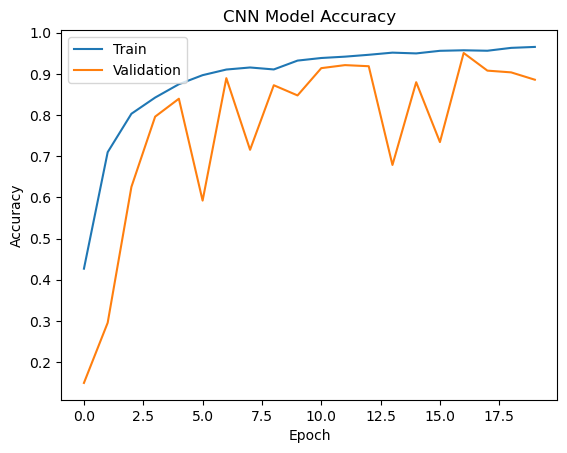

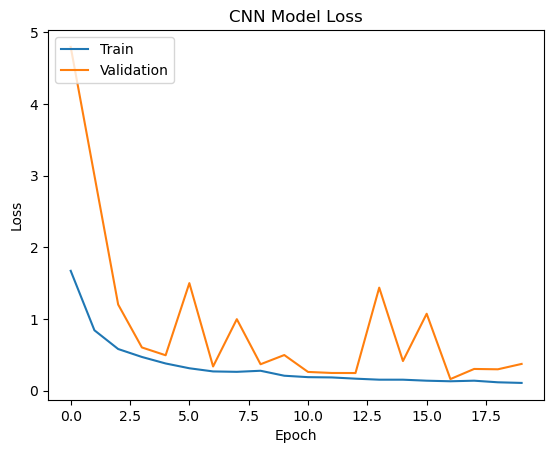

In [188]:
train_val_plot(model2_history, 'CNN')


## Third Model -> VGG16

In [189]:
train_generator, val_generator, test_generator = imagedatageneration(train_dir, val_dir, test_dir)

Found 13451 images belonging to 10 classes.
Found 4481 images belonging to 10 classes.
Found 4492 images belonging to 10 classes.


In [190]:
pretrained_model = VGG16(weights = 'imagenet', include_top = False, input_shape = (256, 256, 3))
pretrained_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 64, 64, 128)       0     

In [191]:
for layer in pretrained_model.layers[:-5]:
    layer.trainable = False
    

In [192]:
# last_layer = pretrained_model.get_layer('block5_pool')
# last_output = last_layer.output

model3 = tf.keras.models.Sequential([ 
    pretrained_model,
    Flatten(),
    Dense(512, activation = 'relu'),
    BatchNormalization(),
    Dense(256, activation = 'relu'),
    BatchNormalization(),
    Dense(256, activation = 'relu'),
    BatchNormalization(),
    Dense(128, activation = 'relu'),
    BatchNormalization(),
    Dense(10, activation = 'softmax')
    
])

In [193]:
model3.compile(optimizer = Adam(learning_rate = 0.001), loss = 'categorical_crossentropy', metrics = ['acc'])
model3.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 8, 8, 512)         14714688  
                                                                 
 flatten_9 (Flatten)         (None, 32768)             0         
                                                                 
 dense_38 (Dense)            (None, 512)               16777728  
                                                                 
 batch_normalization_34 (Ba  (None, 512)               2048      
 tchNormalization)                                               
                                                                 
 dense_39 (Dense)            (None, 256)               131328    
                                                                 
 batch_normalization_35 (Ba  (None, 256)               1024      
 tchNormalization)                                    

In [194]:
model3_history =  model3.fit(train_generator,
          epochs = 20,
          verbose = 1,
          validation_data = val_generator,
          callbacks = [es])


# model3.fit(train_generator,
#           steps_per_epoch = 250,
#           epochs = 20,
#           verbose = 1,
#           validation_steps = 50,
#           validation_data = val_generator,
#           callbacks = [es])

Epoch 1/20
421/421 [==============================] - 1341s 3s/step - loss: 1.2883 - acc: 0.5593 - val_loss: 2.5869 - val_acc: 0.4439
Epoch 2/20
421/421 [==============================] - 1510s 4s/step - loss: 0.4201 - acc: 0.8618 - val_loss: 43.2046 - val_acc: 0.1227
Epoch 3/20
421/421 [==============================] - 3678s 9s/step - loss: 0.3006 - acc: 0.9045 - val_loss: 1.3557 - val_acc: 0.6394
Epoch 4/20
421/421 [==============================] - 55244s 132s/step - loss: 0.1930 - acc: 0.9384 - val_loss: 0.2639 - val_acc: 0.9134
Epoch 5/20
421/421 [==============================] - 1347s 3s/step - loss: 0.2339 - acc: 0.9268 - val_loss: 0.6882 - val_acc: 0.7985
Epoch 6/20
421/421 [==============================] - 1508s 4s/step - loss: 0.1387 - acc: 0.9592 - val_loss: 0.4087 - val_acc: 0.9449
Epoch 7/20
421/421 [==============================] - 1345s 3s/step - loss: 0.1552 - acc: 0.9538 - val_loss: 5.1074 - val_acc: 0.5231
Epoch 8/20
421/421 [==============================] - 1365

In [195]:
accuracy = model3.evaluate(test_generator)

print("Accuracy based on our VGG16 Model :- {:.2f}%".format(accuracy[1]*100))

4492/4492 [==============================] - 404s 90ms/step - loss: 0.0843 - acc: 0.9813
Accuracy based on our VGG16 Model :- 98.13%


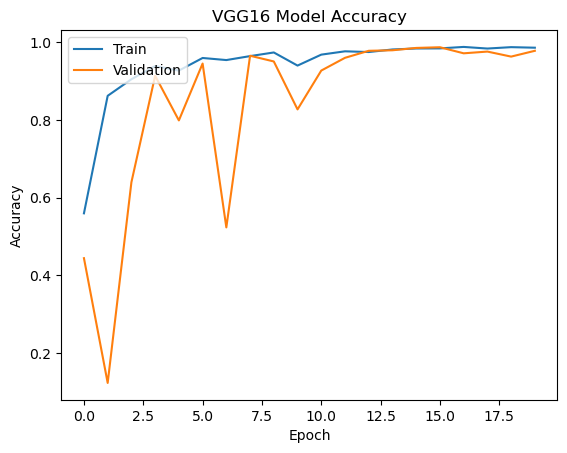

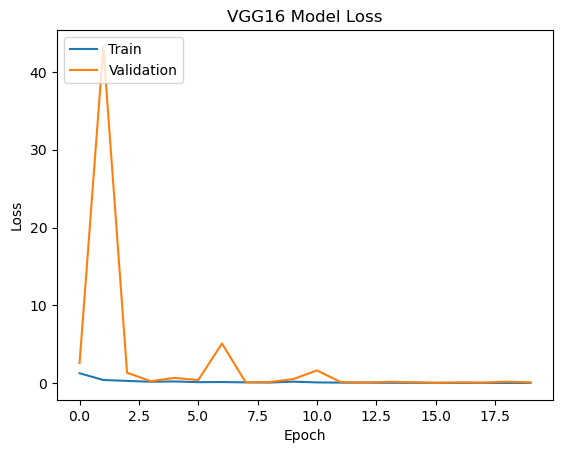

In [196]:
train_val_plot(model3_history, 'VGG16')


## Fourth Model -> ResNet50

In [197]:
train_generator, val_generator, test_generator = imagedatageneration(train_dir, val_dir, test_dir)

Found 13451 images belonging to 10 classes.
Found 4481 images belonging to 10 classes.
Found 4492 images belonging to 10 classes.


In [198]:
pretrained_model = ResNet50(weights = 'imagenet', include_top = False, input_shape = (256, 256, 3))

In [199]:
for layer in pretrained_model.layers[:-3]:
    layer.trainable = False

In [200]:
model4 = tf.keras.models.Sequential([ 
    pretrained_model,
    Flatten(),
    Dense(512, activation = 'relu'),
    BatchNormalization(),
    Dense(256, activation = 'relu'),
    BatchNormalization(),
    Dense(256, activation = 'relu'),
    BatchNormalization(),
    Dense(128, activation = 'relu'),
    BatchNormalization(),
    Dense(10, activation = 'softmax')
])

In [201]:
model4.compile(optimizer = Adam(learning_rate = 0.001), loss = 'categorical_crossentropy', metrics = ['acc'])
model4.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 8, 8, 2048)        23587712  
                                                                 
 flatten_10 (Flatten)        (None, 131072)            0         
                                                                 
 dense_43 (Dense)            (None, 512)               67109376  
                                                                 
 batch_normalization_38 (Ba  (None, 512)               2048      
 tchNormalization)                                               
                                                                 
 dense_44 (Dense)            (None, 256)               131328    
                                                                 
 batch_normalization_39 (Ba  (None, 256)               1024      
 tchNormalization)                                   

In [202]:
model4_history = model4.fit(train_generator,
          epochs = 20,
          verbose = 1,
          validation_data = val_generator,
          callbacks = [es])


# model4.fit(train_generator,
#           steps_per_epoch = 250,
#           epochs = 20,
#           verbose = 1,
#           validation_steps = 50,
#           validation_data = val_generator,
#           callbacks = [es])

Epoch 1/20
421/421 [==============================] - 425s 1s/step - loss: 1.7885 - acc: 0.3766 - val_loss: 1.5744 - val_acc: 0.4564
Epoch 2/20
421/421 [==============================] - 429s 1s/step - loss: 1.2468 - acc: 0.5672 - val_loss: 1.2521 - val_acc: 0.5840
Epoch 3/20
421/421 [==============================] - 437s 1s/step - loss: 1.0413 - acc: 0.6482 - val_loss: 1.1190 - val_acc: 0.6206
Epoch 4/20
421/421 [==============================] - 431s 1s/step - loss: 0.8806 - acc: 0.7023 - val_loss: 0.9537 - val_acc: 0.6740
Epoch 5/20
421/421 [==============================] - 438s 1s/step - loss: 0.8034 - acc: 0.7266 - val_loss: 0.8327 - val_acc: 0.7137
Epoch 6/20
421/421 [==============================] - 449s 1s/step - loss: 0.7120 - acc: 0.7607 - val_loss: 0.8250 - val_acc: 0.7306
Epoch 7/20
421/421 [==============================] - 454s 1s/step - loss: 0.6739 - acc: 0.7712 - val_loss: 0.6644 - val_acc: 0.7764
Epoch 8/20
421/421 [==============================] - 445s 1s/step - 

In [203]:
accuracy = model4.evaluate(test_generator)

print("Accuracy based on our ResNet50 Model :- {:.2f}%".format(accuracy[1]*100))

4492/4492 [==============================] - 316s 70ms/step - loss: 0.3689 - acc: 0.8789
Accuracy based on our ResNet50 Model :- 87.89%


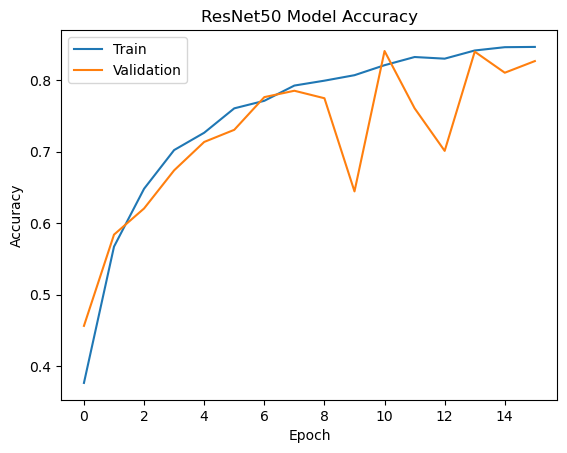

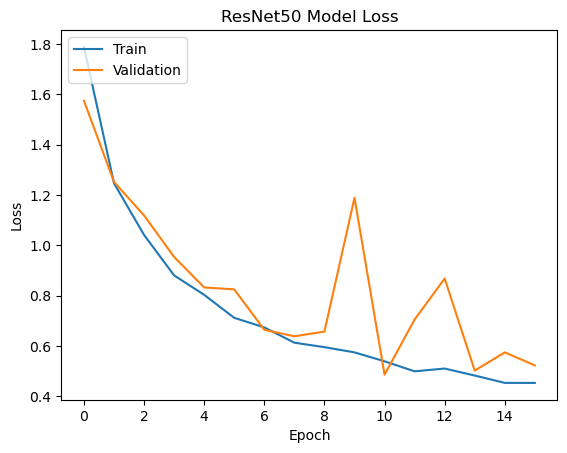

In [204]:
train_val_plot(model4_history, 'ResNet50')


## Fifth Model -> Yolo v8

In [205]:
model5 = YOLO('yolov8n-cls.pt')

In [ ]:
# splitfolders.ratio("../datasets/state-farm-distracted-driver-detection/imgs/train", output="../datasets/state-farm-distracted-driver-detection/output", seed = 1337, ratio=(0.7, 0.15, 0.15))

In [206]:
results = model5.train(data = parent_dir, epochs = 20)
# results = model5.train(data = "../datasets/state-farm-distracted-driver-detection/output", epochs = 10)

New https://pypi.org/project/ultralytics/8.2.47 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.2.38 🚀 Python-3.10.14 torch-2.3.1 CPU (Apple M2 Max)
engine/trainer: task=classify, mode=train, model=yolov8n-cls.pt, data=../datasets/state-farm-distracted-driver-detection/cleaned_dataset, epochs=20, time=None, patience=100, batch=16, imgsz=224, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train3, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False,

train: Scanning /Users/deep/Desktop/Data_Science_Projects/datasets/state-farm-distracted-driver-detection/cleaned_dataset/train... 13451 images, 0 corrupt: 10
val: Scanning /Users/deep/Desktop/Data_Science_Projects/datasets/state-farm-distracted-driver-detection/cleaned_dataset/val... 4481 images, 0 corrupt: 100%|██


optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000714, momentum=0.9) with parameter groups 26 weight(decay=0.0), 27 weight(decay=0.0005), 27 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 224 train, 224 val
Using 0 dataloader workers
Logging results to runs/classify/train3
Starting training for 20 epochs...

      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 141/141 [01:27<00:00,  1.62it/s]

                   all      0.937      0.997



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 141/141 [01:25<00:00,  1.66it/s]

                   all      0.969      0.998



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 141/141 [01:24<00:00,  1.67it/s]

                   all      0.977      0.999



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 141/141 [01:24<00:00,  1.66it/s]

                   all      0.986      0.999



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 141/141 [01:24<00:00,  1.67it/s]

                   all      0.987      0.999



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 141/141 [01:23<00:00,  1.69it/s]

                   all      0.989      0.999



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 141/141 [01:25<00:00,  1.65it/s]

                   all      0.992          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 141/141 [01:24<00:00,  1.66it/s]

                   all      0.989          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 141/141 [01:27<00:00,  1.61it/s]

                   all      0.994          1



      Epoch    GPU_mem       loss  Instances       Size


      10/20         0G    0.09131         11        224: 100%|██████████| 841/841 [38:40<00:00,  2.76s/it]    
               classes   top1_acc   top5_acc: 100%|██████████| 141/141 [01:19<00:00,  1.77it/s]

                   all      0.993          1



      Epoch    GPU_mem       loss  Instances       Size


      11/20         0G    0.08188         11        224: 100%|██████████| 841/841 [08:13<00:00,  1.70it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 141/141 [01:24<00:00,  1.66it/s]

                   all      0.992          1



      Epoch    GPU_mem       loss  Instances       Size


      12/20         0G    0.07662         11        224: 100%|██████████| 841/841 [16:05<00:00,  1.15s/it]    
               classes   top1_acc   top5_acc: 100%|██████████| 141/141 [04:25<00:00,  1.89s/it]

                   all      0.993          1



      Epoch    GPU_mem       loss  Instances       Size


      13/20         0G     0.0684         11        224: 100%|██████████| 841/841 [11:50<00:00,  1.18it/s]  
               classes   top1_acc   top5_acc: 100%|██████████| 141/141 [01:20<00:00,  1.75it/s]

                   all      0.993          1



      Epoch    GPU_mem       loss  Instances       Size


      14/20         0G    0.06641         11        224: 100%|██████████| 841/841 [16:28<00:00,  1.17s/it]   
               classes   top1_acc   top5_acc: 100%|██████████| 141/141 [01:43<00:00,  1.37it/s]

                   all      0.995          1



      Epoch    GPU_mem       loss  Instances       Size


      15/20         0G    0.05784         11        224: 100%|██████████| 841/841 [6:04:29<00:00, 26.00s/it]    
               classes   top1_acc   top5_acc: 100%|██████████| 141/141 [1:44:16<00:00, 44.37s/it]  

                   all      0.996          1



      Epoch    GPU_mem       loss  Instances       Size


      16/20         0G    0.04901         11        224: 100%|██████████| 841/841 [07:51<00:00,  1.78it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 141/141 [01:24<00:00,  1.67it/s]

                   all      0.995          1



      Epoch    GPU_mem       loss  Instances       Size


      17/20         0G    0.04882         11        224: 100%|██████████| 841/841 [08:07<00:00,  1.72it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 141/141 [01:26<00:00,  1.63it/s]

                   all      0.995          1



      Epoch    GPU_mem       loss  Instances       Size


      18/20         0G    0.05147         11        224: 100%|██████████| 841/841 [08:17<00:00,  1.69it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 141/141 [01:25<00:00,  1.65it/s]

                   all      0.995          1



      Epoch    GPU_mem       loss  Instances       Size


      19/20         0G    0.04652         11        224: 100%|██████████| 841/841 [08:12<00:00,  1.71it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 141/141 [01:25<00:00,  1.65it/s]

                   all      0.995          1



      Epoch    GPU_mem       loss  Instances       Size


      20/20         0G    0.04075         11        224: 100%|██████████| 841/841 [08:16<00:00,  1.69it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 141/141 [01:25<00:00,  1.66it/s]

                   all      0.995          1



20 epochs completed in 11.753 hours.
Optimizer stripped from runs/classify/train3/weights/last.pt, 3.0MB
Optimizer stripped from runs/classify/train3/weights/best.pt, 3.0MB

Validating runs/classify/train3/weights/best.pt...
Ultralytics YOLOv8.2.38 🚀 Python-3.10.14 torch-2.3.1 CPU (Apple M2 Max)
YOLOv8n-cls summary (fused): 73 layers, 1447690 parameters, 0 gradients, 3.3 GFLOPs
train: /Users/deep/Desktop/Data_Science_Projects/datasets/state-farm-distracted-driver-detection/cleaned_dataset/train... found 13451 images in 10 classes ✅ 
val: /Users/deep/Desktop/Data_Science_Projects/datasets/state-farm-distracted-driver-detection/cleaned_dataset/val... found 4481 images in 10 classes ✅ 
test: /Users/deep/Desktop/Data_Science_Projects/datasets/state-farm-distracted-driver-detection/cleaned_dataset/test... found 4492 images in 10 classes ✅ 


               classes   top1_acc   top5_acc: 100%|██████████| 141/141 [01:20<00:00,  1.75it/s]


                   all      0.996          1
Speed: 0.0ms preprocess, 15.6ms inference, 0.0ms loss, 0.0ms postprocess per image
Results saved to runs/classify/train3
Results saved to runs/classify/train3


In [207]:
model5.val()

Ultralytics YOLOv8.2.38 🚀 Python-3.10.14 torch-2.3.1 CPU (Apple M2 Max)
YOLOv8n-cls summary (fused): 73 layers, 1447690 parameters, 0 gradients, 3.3 GFLOPs
train: /Users/deep/Desktop/Data_Science_Projects/datasets/state-farm-distracted-driver-detection/cleaned_dataset/train... found 13451 images in 10 classes ✅ 
val: /Users/deep/Desktop/Data_Science_Projects/datasets/state-farm-distracted-driver-detection/cleaned_dataset/val... found 4481 images in 10 classes ✅ 
test: /Users/deep/Desktop/Data_Science_Projects/datasets/state-farm-distracted-driver-detection/cleaned_dataset/test... found 4492 images in 10 classes ✅ 


val: Scanning /Users/deep/Desktop/Data_Science_Projects/datasets/state-farm-distracted-driver-detection/cleaned_dataset/val... 4481 images, 0 corrupt: 100%|██
               classes   top1_acc   top5_acc: 100%|██████████| 281/281 [01:25<00:00,  3.30it/s]


                   all      0.996          1
Speed: 0.0ms preprocess, 16.5ms inference, 0.0ms loss, 0.0ms postprocess per image
Results saved to runs/classify/train32


ultralytics.utils.metrics.ClassifyMetrics object with attributes:

confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x417e253c0>
curves: []
curves_results: []
fitness: 0.9977683424949646
keys: ['metrics/accuracy_top1', 'metrics/accuracy_top5']
results_dict: {'metrics/accuracy_top1': 0.9955366849899292, 'metrics/accuracy_top5': 1.0, 'fitness': 0.9977683424949646}
save_dir: PosixPath('runs/classify/train32')
speed: {'preprocess': 0.0004301218017087773, 'inference': 16.4976419015964, 'loss': 9.289864742497838e-05, 'postprocess': 6.629536923913119e-05}
task: 'classify'
top1: 0.9955366849899292
top5: 1.0

In [209]:
df= pd.read_csv('./runs/classify/train3/results.csv')
df.head()

,epoch,train/loss,metrics/accuracy_top1,metrics/accuracy_top5,val/loss,lr/pg0,lr/pg1,lr/pg2
0,1,1.39470,0.93662,0.99732,1.5717,0.000238,0.000238,0.000238
1,2,0.35905,0.96853,0.99844,1.5082,0.000452,0.000452,0.000452
2,3,0.26130,0.97657,0.99888,1.4941,0.000643,0.000643,0.000643
3,4,0.21014,0.98639,0.99911,1.4830,0.000608,0.000608,0.000608
4,5,0.16759,0.98683,0.99866,1.4785,0.000573,0.000573,0.000573


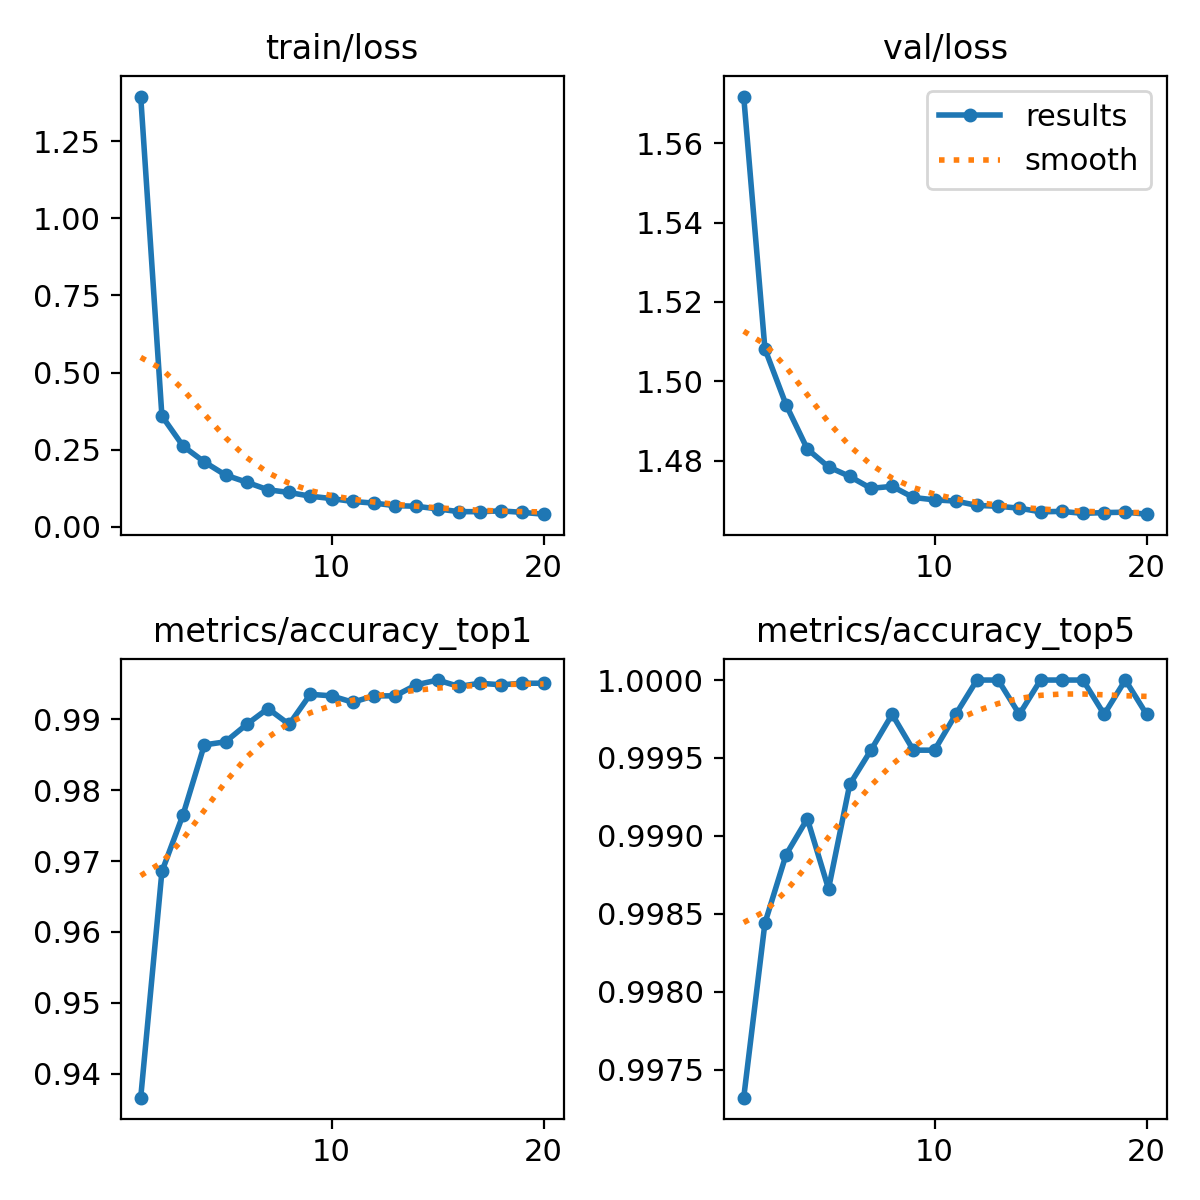

In [210]:
Image("./runs/classify/train3/results.png")

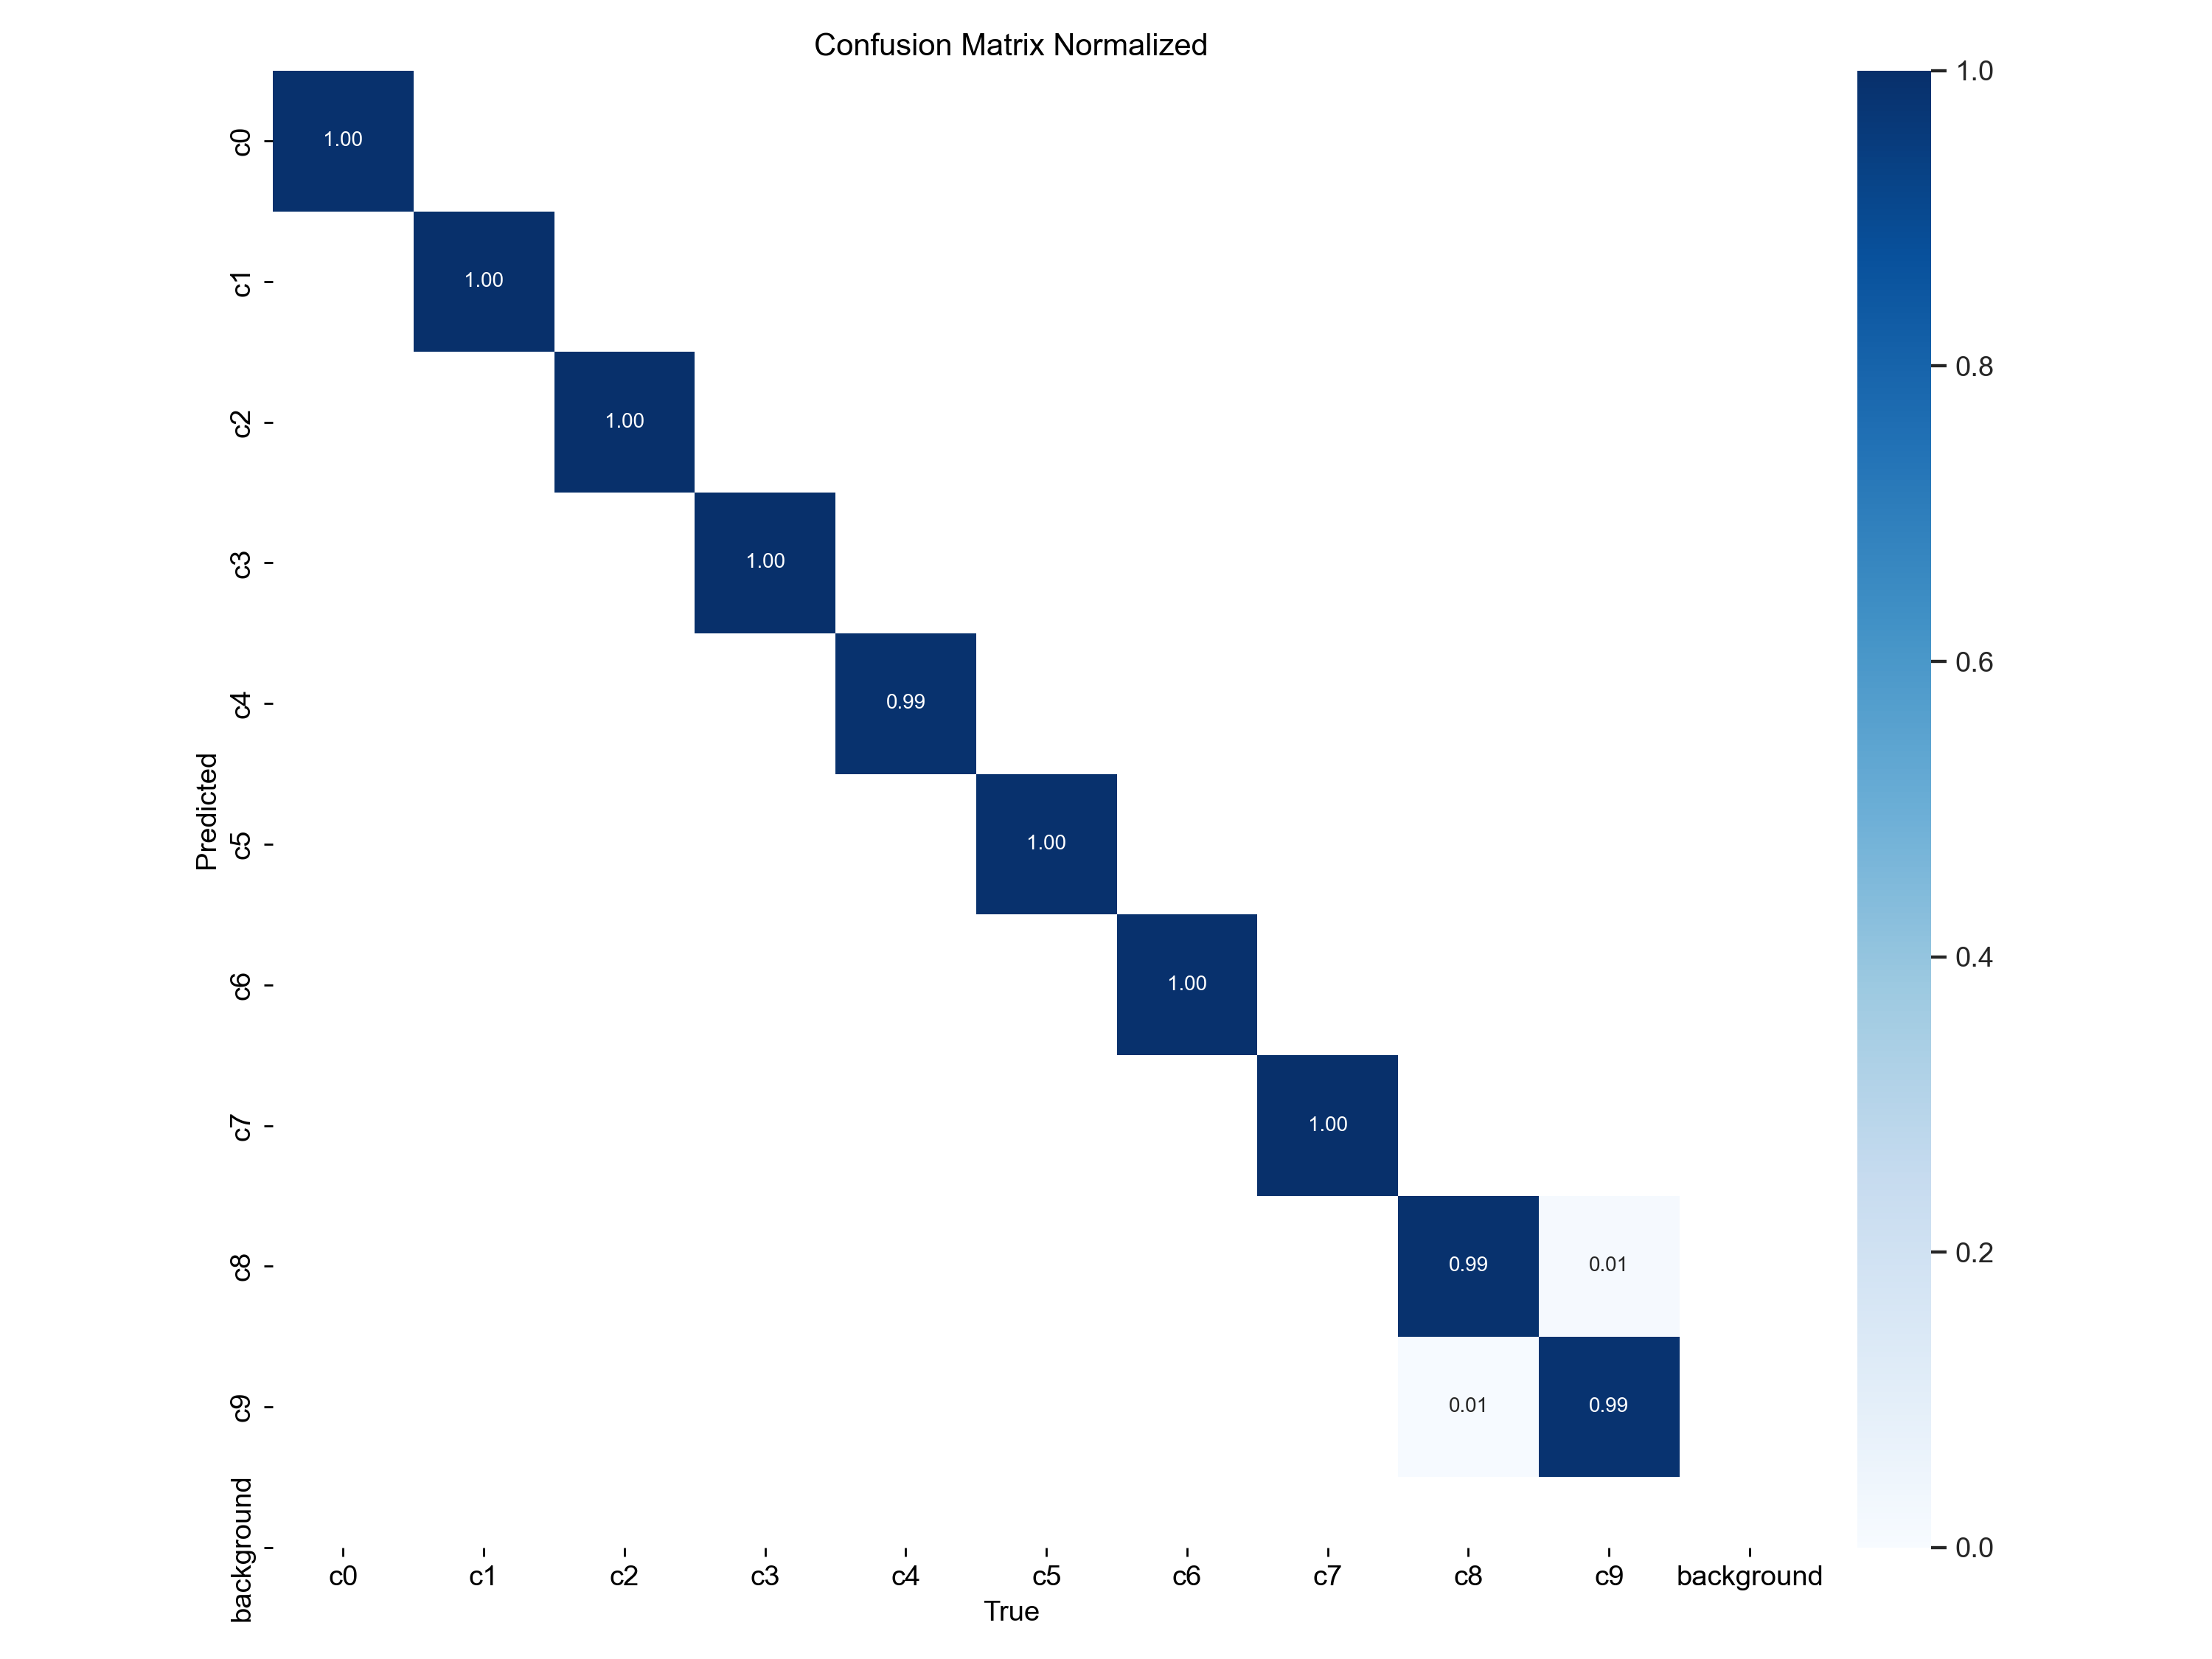

In [211]:
Image("./runs/classify/train3/confusion_matrix_normalized.png")


In [ ]:
# classes = ['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9']
# path = "../datasets/state-farm-distracted-driver-detection/output/test/c1/"
# actual_class = 1
# model_weights = "./runs/classify/train2/weights/best.pt"
# pred = [(path+i,model5.predict(path+i, model = model_weights)[0].probs.top1, actual_class) for i in os.listdir(path)[:45]]

In [212]:
classes = ['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9']
test_images_path = test_dir
model_weights = "./runs/classify/train3/weights/best.pt"

predicted_list = []

for clas in classes:
    image_dir = os.path.join(test_images_path, clas)
    # print(image_dir)
    images_list = os.listdir(image_dir)
    # print(images_list)
    # Class label in the form of 0 to 9
    class_label = int(clas[-1])
    # print(class_label)
    for image in images_list:
        path = os.path.join(image_dir, image)
        # print(path)
        y_actual = class_label
        y_predicted = model5.predict(path, model = model_weights)[0].probs.top1
        predicted_list.append([path, y_actual, y_predicted])


image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c0/img_1487.jpg: 224x224 c0 1.00, c4 0.00, c3 0.00, c8 0.00, c5 0.00, 11.1ms
Speed: 2.7ms preprocess, 11.1ms inference, 0.1ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c0/img_34518.jpg: 224x224 c0 1.00, c5 0.00, c3 0.00, c9 0.00, c8 0.00, 7.4ms
Speed: 3.7ms preprocess, 7.4ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c0/img_35809.jpg: 224x224 c0 1.00, c1 0.00, c5 0.00, c6 0.00, c9 0.00, 9.3ms
Speed: 3.4ms preprocess, 9.3ms inference, 0.0ms postprocess per image at shape (1, 3

Speed: 2.0ms preprocess, 6.2ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c0/img_40930.jpg: 224x224 c0 1.00, c9 0.00, c3 0.00, c1 0.00, c5 0.00, 9.1ms
Speed: 1.9ms preprocess, 9.1ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c0/img_20746.jpg: 224x224 c0 1.00, c1 0.00, c3 0.00, c5 0.00, c2 0.00, 5.7ms
Speed: 1.9ms preprocess, 5.7ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c0/img_60835.jpg: 224x224 c0 1.00, c8 0.00, c5 0.00, c3 0.00, c9 0

Speed: 1.8ms preprocess, 5.5ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c0/img_90333.jpg: 224x224 c0 1.00, c3 0.00, c4 0.00, c5 0.00, c8 0.00, 5.4ms
Speed: 1.7ms preprocess, 5.4ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c0/img_14999.jpg: 224x224 c0 1.00, c7 0.00, c8 0.00, c9 0.00, c5 0.00, 9.3ms
Speed: 1.6ms preprocess, 9.3ms inference, 0.6ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c0/img_90327.jpg: 224x224 c0 1.00, c9 0.00, c5 0.00, c7 0.00, c8 0

Speed: 3.7ms preprocess, 10.5ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c0/img_40328.jpg: 224x224 c0 1.00, c5 0.00, c1 0.00, c9 0.00, c8 0.00, 8.4ms
Speed: 1.9ms preprocess, 8.4ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c0/img_77590.jpg: 224x224 c0 1.00, c5 0.00, c4 0.00, c3 0.00, c2 0.00, 5.8ms
Speed: 2.0ms preprocess, 5.8ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c0/img_55719.jpg: 224x224 c0 1.00, c5 0.00, c6 0.00, c3 0.00, c4 

Speed: 2.1ms preprocess, 10.1ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c0/img_78893.jpg: 224x224 c0 1.00, c1 0.00, c9 0.00, c2 0.00, c6 0.00, 7.4ms
Speed: 3.4ms preprocess, 7.4ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c0/img_51232.jpg: 224x224 c0 1.00, c5 0.00, c9 0.00, c6 0.00, c1 0.00, 5.6ms
Speed: 1.9ms preprocess, 5.6ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c0/img_2028.jpg: 224x224 c0 1.00, c5 0.00, c3 0.00, c1 0.00, c2 0

Speed: 2.4ms preprocess, 6.0ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c0/img_47634.jpg: 224x224 c0 1.00, c1 0.00, c3 0.00, c9 0.00, c5 0.00, 7.4ms
Speed: 3.5ms preprocess, 7.4ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c0/img_97165.jpg: 224x224 c0 1.00, c5 0.00, c9 0.00, c8 0.00, c1 0.00, 6.2ms
Speed: 2.0ms preprocess, 6.2ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c0/img_11658.jpg: 224x224 c0 1.00, c3 0.00, c1 0.00, c5 0.00, c2 0

Speed: 1.5ms preprocess, 5.2ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c0/img_47804.jpg: 224x224 c0 1.00, c5 0.00, c7 0.00, c9 0.00, c1 0.00, 6.0ms
Speed: 2.5ms preprocess, 6.0ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c0/img_32280.jpg: 224x224 c0 1.00, c1 0.00, c5 0.00, c6 0.00, c2 0.00, 10.9ms
Speed: 1.9ms preprocess, 10.9ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c0/img_96522.jpg: 224x224 c0 1.00, c3 0.00, c1 0.00, c2 0.00, c6

Speed: 1.7ms preprocess, 6.7ms inference, 1.3ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c0/img_73626.jpg: 224x224 c0 1.00, c9 0.00, c5 0.00, c8 0.00, c7 0.00, 5.2ms
Speed: 1.5ms preprocess, 5.2ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c0/img_37058.jpg: 224x224 c0 1.00, c5 0.00, c3 0.00, c1 0.00, c6 0.00, 6.8ms
Speed: 2.3ms preprocess, 6.8ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c0/img_76028.jpg: 224x224 c0 1.00, c5 0.00, c9 0.00, c2 0.00, c1 0

Speed: 2.2ms preprocess, 5.6ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c0/img_75497.jpg: 224x224 c0 1.00, c5 0.00, c1 0.00, c3 0.00, c9 0.00, 6.3ms
Speed: 1.7ms preprocess, 6.3ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c0/img_69280.jpg: 224x224 c0 1.00, c5 0.00, c9 0.00, c2 0.00, c3 0.00, 8.8ms
Speed: 2.8ms preprocess, 8.8ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c0/img_71418.jpg: 224x224 c0 1.00, c5 0.00, c3 0.00, c2 0.00, c4 0

Speed: 1.5ms preprocess, 5.2ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c0/img_82948.jpg: 224x224 c0 1.00, c9 0.00, c8 0.00, c1 0.00, c5 0.00, 6.4ms
Speed: 3.1ms preprocess, 6.4ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c0/img_60098.jpg: 224x224 c0 1.00, c5 0.00, c8 0.00, c9 0.00, c1 0.00, 6.4ms
Speed: 3.8ms preprocess, 6.4ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c0/img_26797.jpg: 224x224 c0 1.00, c7 0.00, c8 0.00, c9 0.00, c5 0

Speed: 2.9ms preprocess, 7.0ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c0/img_800.jpg: 224x224 c0 1.00, c1 0.00, c9 0.00, c2 0.00, c6 0.00, 8.2ms
Speed: 2.5ms preprocess, 8.2ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c0/img_27877.jpg: 224x224 c0 0.99, c3 0.01, c4 0.00, c2 0.00, c6 0.00, 10.6ms
Speed: 2.2ms preprocess, 10.6ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c0/img_18339.jpg: 224x224 c0 1.00, c5 0.00, c3 0.00, c8 0.00, c9 0


image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c0/img_31345.jpg: 224x224 c0 1.00, c3 0.00, c9 0.00, c2 0.00, c4 0.00, 9.0ms
Speed: 2.1ms preprocess, 9.0ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c0/img_2695.jpg: 224x224 c0 1.00, c5 0.00, c1 0.00, c9 0.00, c6 0.00, 9.0ms
Speed: 2.6ms preprocess, 9.0ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c0/img_93094.jpg: 224x224 c0 1.00, c9 0.00, c3 0.00, c5 0.00, c4 0.00, 6.5ms
Speed: 2.9ms preprocess, 6.5ms inference, 0.0ms postprocess per image at shape (1, 3, 

Speed: 2.9ms preprocess, 7.9ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c0/img_99779.jpg: 224x224 c0 1.00, c9 0.00, c5 0.00, c3 0.00, c4 0.00, 6.0ms
Speed: 2.3ms preprocess, 6.0ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c0/img_18267.jpg: 224x224 c0 1.00, c5 0.00, c9 0.00, c6 0.00, c2 0.00, 5.3ms
Speed: 1.7ms preprocess, 5.3ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c0/img_54086.jpg: 224x224 c0 1.00, c1 0.00, c5 0.00, c6 0.00, c3 0

Speed: 2.8ms preprocess, 5.8ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c0/img_32930.jpg: 224x224 c0 1.00, c9 0.00, c8 0.00, c5 0.00, c7 0.00, 5.4ms
Speed: 1.5ms preprocess, 5.4ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c0/img_39865.jpg: 224x224 c0 1.00, c5 0.00, c1 0.00, c2 0.00, c6 0.00, 5.5ms
Speed: 1.5ms preprocess, 5.5ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c0/img_54337.jpg: 224x224 c0 1.00, c1 0.00, c5 0.00, c9 0.00, c3 0


image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c0/img_1367.jpg: 224x224 c0 1.00, c1 0.00, c9 0.00, c2 0.00, c6 0.00, 6.8ms
Speed: 3.0ms preprocess, 6.8ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c0/img_93090.jpg: 224x224 c0 1.00, c5 0.00, c9 0.00, c6 0.00, c8 0.00, 6.0ms
Speed: 3.1ms preprocess, 6.0ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c0/img_65060.jpg: 224x224 c0 0.98, c3 0.01, c4 0.01, c9 0.00, c8 0.00, 8.9ms
Speed: 1.6ms preprocess, 8.9ms inference, 0.0ms postprocess per image at shape (1, 3, 

Speed: 3.1ms preprocess, 7.7ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c0/img_16714.jpg: 224x224 c0 1.00, c8 0.00, c6 0.00, c5 0.00, c1 0.00, 9.2ms
Speed: 2.0ms preprocess, 9.2ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c0/img_71758.jpg: 224x224 c0 1.00, c9 0.00, c1 0.00, c2 0.00, c3 0.00, 5.7ms
Speed: 2.1ms preprocess, 5.7ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c0/img_24771.jpg: 224x224 c0 1.00, c9 0.00, c1 0.00, c5 0.00, c8 0

Speed: 3.3ms preprocess, 6.9ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c0/img_75599.jpg: 224x224 c0 1.00, c1 0.00, c5 0.00, c6 0.00, c3 0.00, 8.3ms
Speed: 4.0ms preprocess, 8.3ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c0/img_90273.jpg: 224x224 c0 1.00, c1 0.00, c5 0.00, c6 0.00, c9 0.00, 5.7ms
Speed: 2.1ms preprocess, 5.7ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c0/img_16980.jpg: 224x224 c0 0.97, c9 0.03, c5 0.00, c3 0.00, c8 0

Speed: 1.6ms preprocess, 5.4ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c0/img_80288.jpg: 224x224 c0 1.00, c1 0.00, c9 0.00, c2 0.00, c3 0.00, 5.8ms
Speed: 2.2ms preprocess, 5.8ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c0/img_68708.jpg: 224x224 c0 1.00, c5 0.00, c1 0.00, c9 0.00, c6 0.00, 5.6ms
Speed: 1.7ms preprocess, 5.6ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c0/img_10314.jpg: 224x224 c0 1.00, c1 0.00, c3 0.00, c2 0.00, c9 0

Speed: 1.5ms preprocess, 5.8ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c0/img_82934.jpg: 224x224 c0 1.00, c1 0.00, c5 0.00, c9 0.00, c3 0.00, 11.0ms
Speed: 2.9ms preprocess, 11.0ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c0/img_44422.jpg: 224x224 c0 1.00, c1 0.00, c9 0.00, c5 0.00, c2 0.00, 6.6ms
Speed: 2.3ms preprocess, 6.6ms inference, 1.5ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c0/img_71499.jpg: 224x224 c0 0.98, c9 0.02, c5 0.01, c8 0.00, c6

Speed: 1.6ms preprocess, 5.6ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c0/img_36854.jpg: 224x224 c0 1.00, c5 0.00, c9 0.00, c2 0.00, c8 0.00, 8.2ms
Speed: 4.1ms preprocess, 8.2ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c0/img_54753.jpg: 224x224 c0 1.00, c7 0.00, c5 0.00, c9 0.00, c8 0.00, 9.0ms
Speed: 2.1ms preprocess, 9.0ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c0/img_65439.jpg: 224x224 c0 1.00, c1 0.00, c9 0.00, c2 0.00, c5 0

Speed: 1.6ms preprocess, 6.0ms inference, 0.9ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c0/img_34515.jpg: 224x224 c0 1.00, c5 0.00, c3 0.00, c9 0.00, c8 0.00, 6.5ms
Speed: 2.9ms preprocess, 6.5ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c1/img_68267.jpg: 224x224 c1 1.00, c6 0.00, c0 0.00, c8 0.00, c2 0.00, 5.6ms
Speed: 1.9ms preprocess, 5.6ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c1/img_62951.jpg: 224x224 c1 1.00, c8 0.00, c2 0.00, c0 0.00, c6 0

Speed: 2.0ms preprocess, 5.7ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c1/img_84999.jpg: 224x224 c1 1.00, c2 0.00, c6 0.00, c8 0.00, c7 0.00, 7.9ms
Speed: 2.8ms preprocess, 7.9ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c1/img_55468.jpg: 224x224 c1 1.00, c6 0.00, c2 0.00, c0 0.00, c8 0.00, 5.6ms
Speed: 2.0ms preprocess, 5.6ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c1/img_37212.jpg: 224x224 c1 1.00, c2 0.00, c6 0.00, c0 0.00, c4 0

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c1/img_22224.jpg: 224x224 c1 1.00, c2 0.00, c6 0.00, c0 0.00, c3 0.00, 8.0ms
Speed: 2.8ms preprocess, 8.0ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c1/img_75368.jpg: 224x224 c1 1.00, c0 0.00, c6 0.00, c2 0.00, c8 0.00, 7.1ms
Speed: 1.9ms preprocess, 7.1ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c1/img_75181.jpg: 224x224 c1 1.00, c6 0.00, c0 0.00, c8 0.00, c2 0.00, 8.6ms
Speed: 1.9ms preprocess, 8.6ms inference, 0.1ms postprocess per image at shape (1, 3, 

Speed: 2.0ms preprocess, 5.9ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c1/img_75152.jpg: 224x224 c1 1.00, c2 0.00, c0 0.00, c6 0.00, c8 0.00, 6.5ms
Speed: 1.6ms preprocess, 6.5ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c1/img_34132.jpg: 224x224 c1 1.00, c2 0.00, c8 0.00, c0 0.00, c6 0.00, 5.6ms
Speed: 1.6ms preprocess, 5.6ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c1/img_6701.jpg: 224x224 c1 1.00, c6 0.00, c5 0.00, c8 0.00, c0 0.

Speed: 2.4ms preprocess, 5.6ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c1/img_1045.jpg: 224x224 c1 1.00, c9 0.00, c0 0.00, c2 0.00, c8 0.00, 8.4ms
Speed: 2.1ms preprocess, 8.4ms inference, 0.5ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c1/img_80443.jpg: 224x224 c1 1.00, c0 0.00, c8 0.00, c6 0.00, c2 0.00, 7.4ms
Speed: 2.1ms preprocess, 7.4ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c1/img_86032.jpg: 224x224 c1 1.00, c2 0.00, c0 0.00, c6 0.00, c8 0.

Speed: 1.6ms preprocess, 5.6ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c1/img_82970.jpg: 224x224 c1 1.00, c2 0.00, c0 0.00, c8 0.00, c6 0.00, 7.6ms
Speed: 3.0ms preprocess, 7.6ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c1/img_17994.jpg: 224x224 c1 1.00, c0 0.00, c2 0.00, c5 0.00, c6 0.00, 5.8ms
Speed: 1.9ms preprocess, 5.8ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c1/img_2477.jpg: 224x224 c1 1.00, c2 0.00, c8 0.00, c6 0.00, c0 0.

Speed: 2.0ms preprocess, 5.9ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c1/img_9130.jpg: 224x224 c1 1.00, c9 0.00, c8 0.00, c0 0.00, c6 0.00, 5.7ms
Speed: 1.6ms preprocess, 5.7ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c1/img_77290.jpg: 224x224 c1 1.00, c6 0.00, c8 0.00, c0 0.00, c2 0.00, 5.8ms
Speed: 2.0ms preprocess, 5.8ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c1/img_87638.jpg: 224x224 c1 1.00, c6 0.00, c0 0.00, c8 0.00, c2 0.

Speed: 2.7ms preprocess, 6.1ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c1/img_37698.jpg: 224x224 c1 1.00, c0 0.00, c9 0.00, c2 0.00, c8 0.00, 7.2ms
Speed: 3.4ms preprocess, 7.2ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c1/img_37868.jpg: 224x224 c1 1.00, c0 0.00, c6 0.00, c2 0.00, c5 0.00, 6.3ms
Speed: 2.4ms preprocess, 6.3ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c1/img_3343.jpg: 224x224 c1 1.00, c0 0.00, c8 0.00, c6 0.00, c2 0.

Speed: 1.6ms preprocess, 5.3ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c1/img_2315.jpg: 224x224 c1 1.00, c0 0.00, c2 0.00, c5 0.00, c6 0.00, 9.4ms
Speed: 3.1ms preprocess, 9.4ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c1/img_28235.jpg: 224x224 c1 1.00, c9 0.00, c0 0.00, c2 0.00, c5 0.00, 8.9ms
Speed: 1.8ms preprocess, 8.9ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c1/img_62300.jpg: 224x224 c1 1.00, c0 0.00, c6 0.00, c2 0.00, c8 0.

Speed: 2.2ms preprocess, 7.1ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c1/img_80996.jpg: 224x224 c1 1.00, c6 0.00, c0 0.00, c8 0.00, c2 0.00, 10.5ms
Speed: 1.8ms preprocess, 10.5ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c1/img_62278.jpg: 224x224 c1 1.00, c6 0.00, c0 0.00, c2 0.00, c8 0.00, 6.1ms
Speed: 2.4ms preprocess, 6.1ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c1/img_57348.jpg: 224x224 c1 1.00, c6 0.00, c8 0.00, c9 0.00, c0

Speed: 2.4ms preprocess, 6.2ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c1/img_11095.jpg: 224x224 c1 1.00, c6 0.00, c0 0.00, c8 0.00, c2 0.00, 7.9ms
Speed: 2.3ms preprocess, 7.9ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c1/img_26639.jpg: 224x224 c1 1.00, c2 0.00, c6 0.00, c8 0.00, c9 0.00, 7.3ms
Speed: 1.8ms preprocess, 7.3ms inference, 1.3ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c1/img_46867.jpg: 224x224 c1 1.00, c2 0.00, c6 0.00, c8 0.00, c7 0

Speed: 2.5ms preprocess, 13.9ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c1/img_69267.jpg: 224x224 c1 1.00, c0 0.00, c6 0.00, c2 0.00, c7 0.00, 11.6ms
Speed: 3.6ms preprocess, 11.6ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c1/img_99751.jpg: 224x224 c1 1.00, c6 0.00, c8 0.00, c0 0.00, c2 0.00, 5.4ms
Speed: 3.0ms preprocess, 5.4ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c1/img_33035.jpg: 224x224 c1 1.00, c2 0.00, c6 0.00, c0 0.00, c

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c1/img_67273.jpg: 224x224 c1 1.00, c6 0.00, c2 0.00, c8 0.00, c5 0.00, 10.1ms
Speed: 1.9ms preprocess, 10.1ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c1/img_33965.jpg: 224x224 c1 1.00, c8 0.00, c0 0.00, c6 0.00, c2 0.00, 8.5ms
Speed: 1.8ms preprocess, 8.5ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c1/img_16267.jpg: 224x224 c1 1.00, c6 0.00, c0 0.00, c2 0.00, c8 0.00, 7.6ms
Speed: 3.9ms preprocess, 7.6ms inference, 0.0ms postprocess per image at shape (1, 3

Speed: 3.6ms preprocess, 9.7ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c1/img_95970.jpg: 224x224 c1 1.00, c0 0.00, c6 0.00, c2 0.00, c5 0.00, 7.4ms
Speed: 1.9ms preprocess, 7.4ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c1/img_58889.jpg: 224x224 c1 1.00, c9 0.00, c6 0.00, c8 0.00, c7 0.00, 6.7ms
Speed: 1.7ms preprocess, 6.7ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c1/img_60331.jpg: 224x224 c1 1.00, c6 0.00, c2 0.00, c8 0.00, c0 0


image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c1/img_67983.jpg: 224x224 c1 1.00, c6 0.00, c8 0.00, c0 0.00, c3 0.00, 11.6ms
Speed: 1.9ms preprocess, 11.6ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c1/img_18831.jpg: 224x224 c1 1.00, c0 0.00, c9 0.00, c6 0.00, c5 0.00, 6.8ms
Speed: 1.7ms preprocess, 6.8ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c1/img_15483.jpg: 224x224 c1 1.00, c6 0.00, c2 0.00, c8 0.00, c0 0.00, 8.7ms
Speed: 3.0ms preprocess, 8.7ms inference, 0.0ms postprocess per image at shape (1, 

Speed: 4.0ms preprocess, 10.3ms inference, 1.1ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c1/img_96164.jpg: 224x224 c1 1.00, c6 0.00, c0 0.00, c2 0.00, c8 0.00, 6.5ms
Speed: 1.8ms preprocess, 6.5ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c1/img_79638.jpg: 224x224 c1 1.00, c2 0.00, c6 0.00, c0 0.00, c8 0.00, 5.3ms
Speed: 1.5ms preprocess, 5.3ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c1/img_21447.jpg: 224x224 c1 1.00, c6 0.00, c2 0.00, c3 0.00, c0 

Speed: 2.0ms preprocess, 5.9ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c1/img_87736.jpg: 224x224 c1 1.00, c6 0.00, c8 0.00, c2 0.00, c0 0.00, 7.3ms
Speed: 2.0ms preprocess, 7.3ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c1/img_78090.jpg: 224x224 c1 1.00, c2 0.00, c6 0.00, c8 0.00, c0 0.00, 6.9ms
Speed: 1.8ms preprocess, 6.9ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c1/img_66053.jpg: 224x224 c1 1.00, c6 0.00, c2 0.00, c8 0.00, c0 0

Speed: 2.3ms preprocess, 10.8ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c1/img_89297.jpg: 224x224 c1 1.00, c2 0.00, c0 0.00, c6 0.00, c8 0.00, 6.2ms
Speed: 3.0ms preprocess, 6.2ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c1/img_64647.jpg: 224x224 c1 1.00, c0 0.00, c6 0.00, c8 0.00, c2 0.00, 7.0ms
Speed: 2.0ms preprocess, 7.0ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c1/img_60435.jpg: 224x224 c1 1.00, c6 0.00, c2 0.00, c0 0.00, c8 

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c1/img_11385.jpg: 224x224 c1 1.00, c6 0.00, c8 0.00, c2 0.00, c0 0.00, 13.0ms
Speed: 2.0ms preprocess, 13.0ms inference, 0.1ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c1/img_6656.jpg: 224x224 c1 1.00, c0 0.00, c6 0.00, c9 0.00, c5 0.00, 9.3ms
Speed: 1.9ms preprocess, 9.3ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c1/img_90710.jpg: 224x224 c1 1.00, c6 0.00, c2 0.00, c4 0.00, c3 0.00, 7.7ms
Speed: 3.0ms preprocess, 7.7ms inference, 0.0ms postprocess per image at shape (1, 3,

Speed: 2.7ms preprocess, 6.5ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c2/img_20430.jpg: 224x224 c2 1.00, c6 0.00, c8 0.00, c1 0.00, c0 0.00, 8.8ms
Speed: 2.1ms preprocess, 8.8ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c2/img_86778.jpg: 224x224 c2 1.00, c1 0.00, c6 0.00, c8 0.00, c0 0.00, 8.2ms
Speed: 3.6ms preprocess, 8.2ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c2/img_22964.jpg: 224x224 c2 1.00, c8 0.00, c6 0.00, c1 0.00, c3 0

Speed: 3.9ms preprocess, 6.1ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c2/img_88794.jpg: 224x224 c2 1.00, c6 0.00, c1 0.00, c8 0.00, c0 0.00, 6.2ms
Speed: 2.1ms preprocess, 6.2ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c2/img_49876.jpg: 224x224 c2 1.00, c6 0.00, c1 0.00, c8 0.00, c9 0.00, 11.3ms
Speed: 3.8ms preprocess, 11.3ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c2/img_97878.jpg: 224x224 c2 1.00, c8 0.00, c1 0.00, c0 0.00, c6

Speed: 3.5ms preprocess, 7.5ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c2/img_26136.jpg: 224x224 c2 1.00, c0 0.00, c8 0.00, c1 0.00, c6 0.00, 5.8ms
Speed: 2.0ms preprocess, 5.8ms inference, 1.4ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c2/img_71718.jpg: 224x224 c2 1.00, c8 0.00, c6 0.00, c1 0.00, c0 0.00, 6.1ms
Speed: 3.0ms preprocess, 6.1ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c2/img_71081.jpg: 224x224 c2 1.00, c0 0.00, c8 0.00, c1 0.00, c9 0

Speed: 1.8ms preprocess, 5.7ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c2/img_16219.jpg: 224x224 c2 1.00, c6 0.00, c1 0.00, c8 0.00, c4 0.00, 8.4ms
Speed: 2.4ms preprocess, 8.4ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c2/img_10697.jpg: 224x224 c2 1.00, c8 0.00, c5 0.00, c6 0.00, c1 0.00, 9.3ms
Speed: 1.9ms preprocess, 9.3ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c2/img_52671.jpg: 224x224 c2 1.00, c8 0.00, c0 0.00, c1 0.00, c6 0

Speed: 2.1ms preprocess, 6.4ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c2/img_83017.jpg: 224x224 c2 1.00, c8 0.00, c5 0.00, c1 0.00, c0 0.00, 6.1ms
Speed: 1.5ms preprocess, 6.1ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c2/img_59519.jpg: 224x224 c2 1.00, c8 0.00, c1 0.00, c4 0.00, c5 0.00, 11.0ms
Speed: 3.5ms preprocess, 11.0ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c2/img_92697.jpg: 224x224 c2 1.00, c8 0.00, c6 0.00, c1 0.00, c0

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c2/img_87149.jpg: 224x224 c2 1.00, c1 0.00, c0 0.00, c6 0.00, c8 0.00, 10.8ms
Speed: 1.9ms preprocess, 10.8ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c2/img_71634.jpg: 224x224 c2 1.00, c6 0.00, c8 0.00, c3 0.00, c1 0.00, 8.0ms
Speed: 3.3ms preprocess, 8.0ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c2/img_69721.jpg: 224x224 c2 1.00, c8 0.00, c0 0.00, c6 0.00, c1 0.00, 7.6ms
Speed: 4.2ms preprocess, 7.6ms inference, 0.0ms postprocess per image at shape (1, 3

Speed: 3.2ms preprocess, 6.8ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c2/img_31212.jpg: 224x224 c2 1.00, c8 0.00, c1 0.00, c6 0.00, c0 0.00, 7.3ms
Speed: 3.2ms preprocess, 7.3ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c2/img_24193.jpg: 224x224 c2 1.00, c6 0.00, c1 0.00, c8 0.00, c0 0.00, 6.0ms
Speed: 2.3ms preprocess, 6.0ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c2/img_21772.jpg: 224x224 c2 1.00, c6 0.00, c8 0.00, c1 0.00, c4 0

Speed: 2.3ms preprocess, 8.6ms inference, 0.1ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c2/img_90036.jpg: 224x224 c2 1.00, c0 0.00, c8 0.00, c1 0.00, c6 0.00, 7.1ms
Speed: 2.8ms preprocess, 7.1ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c2/img_33951.jpg: 224x224 c2 1.00, c8 0.00, c0 0.00, c1 0.00, c6 0.00, 8.1ms
Speed: 3.1ms preprocess, 8.1ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c2/img_58128.jpg: 224x224 c2 1.00, c8 0.00, c1 0.00, c9 0.00, c6 0

Speed: 2.5ms preprocess, 8.5ms inference, 0.5ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c2/img_101898.jpg: 224x224 c2 1.00, c6 0.00, c1 0.00, c8 0.00, c9 0.00, 6.2ms
Speed: 2.9ms preprocess, 6.2ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c2/img_77848.jpg: 224x224 c2 1.00, c6 0.00, c8 0.00, c1 0.00, c9 0.00, 5.6ms
Speed: 2.3ms preprocess, 5.6ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c2/img_18257.jpg: 224x224 c2 1.00, c6 0.00, c8 0.00, c0 0.00, c9 

Speed: 1.9ms preprocess, 5.7ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c2/img_30296.jpg: 224x224 c2 1.00, c8 0.00, c1 0.00, c9 0.00, c6 0.00, 8.7ms
Speed: 2.5ms preprocess, 8.7ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c2/img_10146.jpg: 224x224 c2 1.00, c8 0.00, c6 0.00, c1 0.00, c0 0.00, 6.0ms
Speed: 2.2ms preprocess, 6.0ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c2/img_34796.jpg: 224x224 c2 1.00, c8 0.00, c9 0.00, c3 0.00, c1 0

Speed: 2.3ms preprocess, 5.9ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c2/img_26822.jpg: 224x224 c2 1.00, c6 0.00, c8 0.00, c1 0.00, c0 0.00, 6.3ms
Speed: 2.0ms preprocess, 6.3ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c2/img_54278.jpg: 224x224 c2 1.00, c8 0.00, c6 0.00, c1 0.00, c0 0.00, 7.1ms
Speed: 1.8ms preprocess, 7.1ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c2/img_92363.jpg: 224x224 c2 1.00, c1 0.00, c8 0.00, c0 0.00, c6 0

Speed: 2.3ms preprocess, 7.6ms inference, 0.9ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c2/img_88728.jpg: 224x224 c2 1.00, c8 0.00, c6 0.00, c1 0.00, c5 0.00, 9.3ms
Speed: 2.5ms preprocess, 9.3ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c2/img_78430.jpg: 224x224 c2 1.00, c8 0.00, c9 0.00, c6 0.00, c0 0.00, 5.7ms
Speed: 2.0ms preprocess, 5.7ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c2/img_31193.jpg: 224x224 c2 1.00, c6 0.00, c8 0.00, c1 0.00, c0 0

Speed: 1.6ms preprocess, 5.4ms inference, 0.1ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c2/img_67501.jpg: 224x224 c2 1.00, c8 0.00, c0 0.00, c1 0.00, c9 0.00, 7.9ms
Speed: 3.0ms preprocess, 7.9ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c2/img_40814.jpg: 224x224 c2 1.00, c1 0.00, c6 0.00, c8 0.00, c0 0.00, 6.2ms
Speed: 2.8ms preprocess, 6.2ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c2/img_48333.jpg: 224x224 c2 1.00, c8 0.00, c4 0.00, c3 0.00, c6 0

Speed: 2.5ms preprocess, 5.7ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c2/img_49364.jpg: 224x224 c2 1.00, c8 0.00, c6 0.00, c1 0.00, c0 0.00, 8.2ms
Speed: 2.7ms preprocess, 8.2ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c2/img_43107.jpg: 224x224 c2 1.00, c8 0.00, c6 0.00, c4 0.00, c3 0.00, 6.8ms
Speed: 1.8ms preprocess, 6.8ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c2/img_38238.jpg: 224x224 c2 1.00, c8 0.00, c9 0.00, c1 0.00, c6 0

Speed: 3.0ms preprocess, 5.8ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c2/img_53367.jpg: 224x224 c2 1.00, c8 0.00, c1 0.00, c6 0.00, c3 0.00, 9.8ms
Speed: 2.9ms preprocess, 9.8ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c2/img_8535.jpg: 224x224 c2 1.00, c6 0.00, c1 0.00, c8 0.00, c9 0.00, 9.2ms
Speed: 3.0ms preprocess, 9.2ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c2/img_54409.jpg: 224x224 c2 1.00, c6 0.00, c8 0.00, c1 0.00, c5 0.

Speed: 2.0ms preprocess, 5.9ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c2/img_15655.jpg: 224x224 c2 1.00, c8 0.00, c6 0.00, c1 0.00, c0 0.00, 9.6ms
Speed: 4.4ms preprocess, 9.6ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c2/img_50686.jpg: 224x224 c2 1.00, c8 0.00, c1 0.00, c6 0.00, c9 0.00, 7.2ms
Speed: 2.4ms preprocess, 7.2ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c2/img_6296.jpg: 224x224 c2 1.00, c6 0.00, c8 0.00, c9 0.00, c0 0.

Speed: 3.2ms preprocess, 8.4ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c2/img_19877.jpg: 224x224 c2 1.00, c8 0.00, c6 0.00, c1 0.00, c0 0.00, 8.5ms
Speed: 1.8ms preprocess, 8.5ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c2/img_35392.jpg: 224x224 c2 1.00, c8 0.00, c6 0.00, c1 0.00, c0 0.00, 5.9ms
Speed: 2.5ms preprocess, 5.9ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c2/img_49729.jpg: 224x224 c2 1.00, c1 0.00, c8 0.00, c6 0.00, c0 0

Speed: 1.9ms preprocess, 5.8ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c2/img_1689.jpg: 224x224 c2 1.00, c8 0.00, c1 0.00, c6 0.00, c0 0.00, 8.0ms
Speed: 3.2ms preprocess, 8.0ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c2/img_53014.jpg: 224x224 c2 1.00, c8 0.00, c6 0.00, c1 0.00, c5 0.00, 9.6ms
Speed: 1.9ms preprocess, 9.6ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c2/img_9564.jpg: 224x224 c2 1.00, c6 0.00, c8 0.00, c1 0.00, c9 0.0

Speed: 2.9ms preprocess, 7.2ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c3/img_25398.jpg: 224x224 c3 1.00, c4 0.00, c6 0.00, c5 0.00, c7 0.00, 5.3ms
Speed: 1.5ms preprocess, 5.3ms inference, 1.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c3/img_83211.jpg: 224x224 c3 1.00, c4 0.00, c0 0.00, c9 0.00, c1 0.00, 6.1ms
Speed: 2.5ms preprocess, 6.1ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c3/img_10096.jpg: 224x224 c3 1.00, c4 0.00, c1 0.00, c0 0.00, c9 0

Speed: 1.6ms preprocess, 5.2ms inference, 1.5ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c3/img_50738.jpg: 224x224 c3 1.00, c4 0.00, c0 0.00, c1 0.00, c5 0.00, 8.2ms
Speed: 3.1ms preprocess, 8.2ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c3/img_86197.jpg: 224x224 c3 1.00, c0 0.00, c1 0.00, c6 0.00, c4 0.00, 5.3ms
Speed: 1.5ms preprocess, 5.3ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c3/img_35349.jpg: 224x224 c3 1.00, c0 0.00, c4 0.00, c5 0.00, c6 0

Speed: 1.7ms preprocess, 5.7ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c3/img_44764.jpg: 224x224 c3 0.97, c4 0.02, c1 0.00, c5 0.00, c9 0.00, 11.9ms
Speed: 1.4ms preprocess, 11.9ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c3/img_55682.jpg: 224x224 c3 1.00, c4 0.00, c0 0.00, c1 0.00, c5 0.00, 6.2ms
Speed: 2.9ms preprocess, 6.2ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c3/img_20553.jpg: 224x224 c3 1.00, c4 0.00, c5 0.00, c9 0.00, c6

Speed: 3.5ms preprocess, 7.9ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c3/img_58215.jpg: 224x224 c3 1.00, c4 0.00, c0 0.00, c1 0.00, c9 0.00, 5.4ms
Speed: 1.8ms preprocess, 5.4ms inference, 1.3ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c3/img_15329.jpg: 224x224 c3 1.00, c0 0.00, c4 0.00, c6 0.00, c1 0.00, 6.0ms
Speed: 1.9ms preprocess, 6.0ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c3/img_77591.jpg: 224x224 c3 1.00, c4 0.00, c1 0.00, c6 0.00, c0 0

Speed: 2.1ms preprocess, 9.9ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c3/img_20178.jpg: 224x224 c3 1.00, c0 0.00, c4 0.00, c5 0.00, c9 0.00, 5.8ms
Speed: 2.0ms preprocess, 5.8ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c3/img_12848.jpg: 224x224 c3 1.00, c9 0.00, c4 0.00, c8 0.00, c5 0.00, 5.7ms
Speed: 1.7ms preprocess, 5.7ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c3/img_30431.jpg: 224x224 c3 1.00, c1 0.00, c4 0.00, c0 0.00, c9 0

Speed: 2.9ms preprocess, 7.6ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c3/img_62932.jpg: 224x224 c3 1.00, c4 0.00, c0 0.00, c5 0.00, c8 0.00, 5.6ms
Speed: 1.5ms preprocess, 5.6ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c3/img_92196.jpg: 224x224 c3 1.00, c4 0.00, c1 0.00, c6 0.00, c0 0.00, 9.2ms
Speed: 1.5ms preprocess, 9.2ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c3/img_33994.jpg: 224x224 c3 1.00, c4 0.00, c5 0.00, c9 0.00, c0 0

Speed: 1.4ms preprocess, 5.8ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c3/img_34546.jpg: 224x224 c3 1.00, c5 0.00, c0 0.00, c4 0.00, c6 0.00, 6.1ms
Speed: 1.6ms preprocess, 6.1ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c3/img_80791.jpg: 224x224 c3 1.00, c4 0.00, c0 0.00, c6 0.00, c1 0.00, 7.4ms
Speed: 2.8ms preprocess, 7.4ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c3/img_98876.jpg: 224x224 c3 1.00, c4 0.00, c0 0.00, c1 0.00, c6 0

Speed: 2.0ms preprocess, 5.7ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c3/img_39288.jpg: 224x224 c3 1.00, c4 0.00, c9 0.00, c5 0.00, c1 0.00, 5.4ms
Speed: 1.6ms preprocess, 5.4ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c3/img_75733.jpg: 224x224 c3 1.00, c0 0.00, c5 0.00, c4 0.00, c1 0.00, 5.5ms
Speed: 3.4ms preprocess, 5.5ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c3/img_6835.jpg: 224x224 c3 0.98, c0 0.02, c1 0.00, c4 0.00, c9 0.

Speed: 1.6ms preprocess, 8.5ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c3/img_3342.jpg: 224x224 c3 1.00, c4 0.00, c0 0.00, c5 0.00, c1 0.00, 7.6ms
Speed: 2.6ms preprocess, 7.6ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c3/img_87172.jpg: 224x224 c3 1.00, c0 0.00, c4 0.00, c5 0.00, c6 0.00, 6.4ms
Speed: 1.7ms preprocess, 6.4ms inference, 1.3ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c3/img_589.jpg: 224x224 c3 1.00, c4 0.00, c6 0.00, c5 0.00, c0 0.00

Speed: 1.6ms preprocess, 5.7ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c3/img_13512.jpg: 224x224 c3 1.00, c0 0.00, c4 0.00, c1 0.00, c6 0.00, 5.6ms
Speed: 1.7ms preprocess, 5.6ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c3/img_63963.jpg: 224x224 c3 1.00, c4 0.00, c1 0.00, c0 0.00, c9 0.00, 7.4ms
Speed: 2.0ms preprocess, 7.4ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c3/img_62880.jpg: 224x224 c3 1.00, c4 0.00, c6 0.00, c9 0.00, c5 0

Speed: 1.8ms preprocess, 5.7ms inference, 1.1ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c3/img_39308.jpg: 224x224 c3 0.99, c9 0.01, c5 0.00, c4 0.00, c6 0.00, 8.6ms
Speed: 2.2ms preprocess, 8.6ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c3/img_17778.jpg: 224x224 c3 0.99, c4 0.01, c0 0.00, c9 0.00, c1 0.00, 7.9ms
Speed: 2.8ms preprocess, 7.9ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c3/img_59173.jpg: 224x224 c3 1.00, c0 0.00, c1 0.00, c2 0.00, c5 0

Speed: 2.1ms preprocess, 5.9ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c3/img_3825.jpg: 224x224 c3 1.00, c0 0.00, c4 0.00, c9 0.00, c1 0.00, 5.7ms
Speed: 1.8ms preprocess, 5.7ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c3/img_3831.jpg: 224x224 c3 1.00, c4 0.00, c9 0.00, c0 0.00, c5 0.00, 5.5ms
Speed: 1.5ms preprocess, 5.5ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c3/img_101856.jpg: 224x224 c3 1.00, c4 0.00, c1 0.00, c9 0.00, c0 0.

Speed: 1.6ms preprocess, 5.7ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c3/img_3950.jpg: 224x224 c3 1.00, c4 0.00, c0 0.00, c1 0.00, c9 0.00, 5.6ms
Speed: 1.5ms preprocess, 5.6ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c3/img_37938.jpg: 224x224 c3 1.00, c4 0.00, c1 0.00, c6 0.00, c9 0.00, 5.6ms
Speed: 1.5ms preprocess, 5.6ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c3/img_68596.jpg: 224x224 c3 1.00, c4 0.00, c6 0.00, c9 0.00, c5 0.

Speed: 1.6ms preprocess, 5.6ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c3/img_54444.jpg: 224x224 c3 1.00, c4 0.00, c1 0.00, c0 0.00, c6 0.00, 5.6ms
Speed: 1.5ms preprocess, 5.6ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c3/img_40419.jpg: 224x224 c3 1.00, c0 0.00, c4 0.00, c5 0.00, c1 0.00, 6.0ms
Speed: 1.8ms preprocess, 6.0ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c3/img_33391.jpg: 224x224 c3 1.00, c0 0.00, c4 0.00, c1 0.00, c6 0

Speed: 1.6ms preprocess, 8.6ms inference, 0.7ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c3/img_84100.jpg: 224x224 c3 1.00, c0 0.00, c1 0.00, c6 0.00, c4 0.00, 9.2ms
Speed: 1.6ms preprocess, 9.2ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c3/img_81736.jpg: 224x224 c3 1.00, c4 0.00, c1 0.00, c0 0.00, c5 0.00, 5.7ms
Speed: 2.2ms preprocess, 5.7ms inference, 0.6ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c3/img_20113.jpg: 224x224 c3 1.00, c4 0.00, c1 0.00, c0 0.00, c9 0

Speed: 1.5ms preprocess, 5.7ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c3/img_73505.jpg: 224x224 c3 1.00, c4 0.00, c0 0.00, c1 0.00, c5 0.00, 9.9ms
Speed: 2.0ms preprocess, 9.9ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c3/img_8911.jpg: 224x224 c3 1.00, c4 0.00, c5 0.00, c6 0.00, c9 0.00, 7.2ms
Speed: 2.7ms preprocess, 7.2ms inference, 0.1ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c3/img_91351.jpg: 224x224 c3 1.00, c1 0.00, c0 0.00, c4 0.00, c6 0.

Speed: 2.2ms preprocess, 6.0ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c3/img_96993.jpg: 224x224 c3 1.00, c0 0.00, c1 0.00, c4 0.00, c6 0.00, 6.0ms
Speed: 2.1ms preprocess, 6.0ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c3/img_74094.jpg: 224x224 c3 1.00, c4 0.00, c1 0.00, c0 0.00, c9 0.00, 8.1ms
Speed: 3.2ms preprocess, 8.1ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c3/img_50308.jpg: 224x224 c3 1.00, c4 0.00, c6 0.00, c0 0.00, c1 0

Speed: 2.1ms preprocess, 6.2ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c3/img_83425.jpg: 224x224 c3 1.00, c4 0.00, c1 0.00, c0 0.00, c2 0.00, 6.7ms
Speed: 1.8ms preprocess, 6.7ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c3/img_62624.jpg: 224x224 c3 1.00, c4 0.00, c9 0.00, c6 0.00, c5 0.00, 6.7ms
Speed: 3.2ms preprocess, 6.7ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c3/img_59315.jpg: 224x224 c3 1.00, c4 0.00, c0 0.00, c6 0.00, c1 0

Speed: 3.4ms preprocess, 8.5ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c3/img_52041.jpg: 224x224 c3 0.97, c9 0.02, c8 0.00, c4 0.00, c0 0.00, 8.4ms
Speed: 2.7ms preprocess, 8.4ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c3/img_1273.jpg: 224x224 c3 1.00, c4 0.00, c1 0.00, c6 0.00, c0 0.00, 6.7ms
Speed: 1.8ms preprocess, 6.7ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c3/img_81225.jpg: 224x224 c3 1.00, c4 0.00, c1 0.00, c0 0.00, c6 0.

Speed: 2.8ms preprocess, 6.4ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c4/img_92903.jpg: 224x224 c4 1.00, c8 0.00, c0 0.00, c2 0.00, c9 0.00, 5.7ms
Speed: 2.1ms preprocess, 5.7ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c4/img_24482.jpg: 224x224 c4 1.00, c8 0.00, c2 0.00, c0 0.00, c6 0.00, 8.2ms
Speed: 3.2ms preprocess, 8.2ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c4/img_34875.jpg: 224x224 c4 1.00, c3 0.00, c0 0.00, c8 0.00, c6 0

Speed: 2.1ms preprocess, 6.2ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c4/img_69350.jpg: 224x224 c4 1.00, c0 0.00, c8 0.00, c3 0.00, c9 0.00, 5.7ms
Speed: 2.3ms preprocess, 5.7ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c4/img_33076.jpg: 224x224 c4 1.00, c3 0.00, c0 0.00, c6 0.00, c8 0.00, 5.8ms
Speed: 1.9ms preprocess, 5.8ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c4/img_31675.jpg: 224x224 c4 1.00, c3 0.00, c0 0.00, c2 0.00, c9 0

Speed: 2.0ms preprocess, 5.7ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c4/img_71730.jpg: 224x224 c4 1.00, c3 0.00, c0 0.00, c2 0.00, c6 0.00, 10.1ms
Speed: 3.2ms preprocess, 10.1ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c4/img_70374.jpg: 224x224 c4 1.00, c3 0.00, c2 0.00, c0 0.00, c8 0.00, 7.0ms
Speed: 1.5ms preprocess, 7.0ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c4/img_96829.jpg: 224x224 c4 1.00, c3 0.00, c9 0.00, c2 0.00, c0

Speed: 3.1ms preprocess, 7.0ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c4/img_14208.jpg: 224x224 c4 1.00, c8 0.00, c6 0.00, c5 0.00, c2 0.00, 6.3ms
Speed: 2.5ms preprocess, 6.3ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c4/img_47888.jpg: 224x224 c4 1.00, c6 0.00, c8 0.00, c3 0.00, c2 0.00, 6.2ms
Speed: 1.9ms preprocess, 6.2ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c4/img_5553.jpg: 224x224 c4 1.00, c6 0.00, c3 0.00, c8 0.00, c2 0.

Speed: 2.6ms preprocess, 6.4ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c4/img_30419.jpg: 224x224 c4 1.00, c6 0.00, c3 0.00, c9 0.00, c2 0.00, 6.4ms
Speed: 2.6ms preprocess, 6.4ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c4/img_53828.jpg: 224x224 c3 0.59, c4 0.40, c0 0.00, c2 0.00, c6 0.00, 5.7ms
Speed: 1.9ms preprocess, 5.7ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c4/img_57333.jpg: 224x224 c4 1.00, c8 0.00, c2 0.00, c9 0.00, c6 0

Speed: 2.0ms preprocess, 9.1ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c4/img_22127.jpg: 224x224 c4 1.00, c0 0.00, c8 0.00, c3 0.00, c5 0.00, 7.2ms
Speed: 2.7ms preprocess, 7.2ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c4/img_16269.jpg: 224x224 c4 1.00, c8 0.00, c2 0.00, c3 0.00, c6 0.00, 7.9ms
Speed: 2.2ms preprocess, 7.9ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c4/img_96469.jpg: 224x224 c4 1.00, c3 0.00, c0 0.00, c8 0.00, c2 0

Speed: 1.5ms preprocess, 5.3ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c4/img_55409.jpg: 224x224 c4 1.00, c9 0.00, c3 0.00, c2 0.00, c5 0.00, 6.8ms
Speed: 1.8ms preprocess, 6.8ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c4/img_66941.jpg: 224x224 c4 1.00, c7 0.00, c2 0.00, c3 0.00, c0 0.00, 6.8ms
Speed: 1.8ms preprocess, 6.8ms inference, 0.1ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c4/img_17174.jpg: 224x224 c4 1.00, c3 0.00, c2 0.00, c8 0.00, c9 0

Speed: 2.1ms preprocess, 9.5ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c4/img_92769.jpg: 224x224 c1 0.57, c4 0.18, c3 0.15, c2 0.06, c6 0.04, 5.3ms
Speed: 1.6ms preprocess, 5.3ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c4/img_41243.jpg: 224x224 c4 1.00, c3 0.00, c9 0.00, c8 0.00, c2 0.00, 7.3ms
Speed: 2.5ms preprocess, 7.3ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c4/img_5525.jpg: 224x224 c4 1.00, c8 0.00, c6 0.00, c2 0.00, c3 0.

Speed: 2.9ms preprocess, 8.7ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c4/img_20286.jpg: 224x224 c4 1.00, c3 0.00, c2 0.00, c8 0.00, c9 0.00, 5.3ms
Speed: 1.4ms preprocess, 5.3ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c4/img_19413.jpg: 224x224 c4 1.00, c9 0.00, c2 0.00, c8 0.00, c6 0.00, 6.9ms
Speed: 3.2ms preprocess, 6.9ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c4/img_75720.jpg: 224x224 c4 1.00, c8 0.00, c5 0.00, c9 0.00, c3 0

Speed: 1.9ms preprocess, 6.1ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c4/img_2499.jpg: 224x224 c4 1.00, c3 0.00, c2 0.00, c8 0.00, c0 0.00, 9.8ms
Speed: 1.9ms preprocess, 9.8ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c4/img_41645.jpg: 224x224 c4 1.00, c3 0.00, c9 0.00, c6 0.00, c5 0.00, 10.3ms
Speed: 2.0ms preprocess, 10.3ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c4/img_78985.jpg: 224x224 c4 1.00, c3 0.00, c6 0.00, c2 0.00, c8 

Speed: 3.4ms preprocess, 6.9ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c4/img_60902.jpg: 224x224 c4 1.00, c2 0.00, c8 0.00, c6 0.00, c3 0.00, 8.1ms
Speed: 1.9ms preprocess, 8.1ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c4/img_97353.jpg: 224x224 c4 1.00, c3 0.00, c9 0.00, c2 0.00, c6 0.00, 9.6ms
Speed: 2.3ms preprocess, 9.6ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c4/img_51506.jpg: 224x224 c4 1.00, c2 0.00, c8 0.00, c3 0.00, c0 0

Speed: 1.5ms preprocess, 9.7ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c4/img_57808.jpg: 224x224 c4 1.00, c3 0.00, c0 0.00, c8 0.00, c9 0.00, 8.4ms
Speed: 3.0ms preprocess, 8.4ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c4/img_89153.jpg: 224x224 c4 1.00, c8 0.00, c3 0.00, c0 0.00, c9 0.00, 5.8ms
Speed: 1.9ms preprocess, 5.8ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c4/img_41717.jpg: 224x224 c4 1.00, c0 0.00, c5 0.00, c3 0.00, c8 0

Speed: 3.3ms preprocess, 8.0ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c4/img_60290.jpg: 224x224 c4 1.00, c8 0.00, c3 0.00, c0 0.00, c6 0.00, 9.3ms
Speed: 3.4ms preprocess, 9.3ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c4/img_92760.jpg: 224x224 c4 1.00, c3 0.00, c9 0.00, c2 0.00, c0 0.00, 7.4ms
Speed: 2.4ms preprocess, 7.4ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c4/img_74971.jpg: 224x224 c4 1.00, c9 0.00, c3 0.00, c0 0.00, c2 0

Speed: 1.7ms preprocess, 8.6ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c4/img_82799.jpg: 224x224 c4 1.00, c6 0.00, c0 0.00, c8 0.00, c5 0.00, 5.7ms
Speed: 2.0ms preprocess, 5.7ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c4/img_49402.jpg: 224x224 c4 1.00, c3 0.00, c9 0.00, c8 0.00, c0 0.00, 7.7ms
Speed: 3.5ms preprocess, 7.7ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c4/img_46527.jpg: 224x224 c4 1.00, c8 0.00, c3 0.00, c2 0.00, c0 0

Speed: 2.0ms preprocess, 7.1ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c4/img_62804.jpg: 224x224 c4 1.00, c8 0.00, c0 0.00, c6 0.00, c3 0.00, 8.8ms
Speed: 3.6ms preprocess, 8.8ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c4/img_97443.jpg: 224x224 c4 1.00, c8 0.00, c0 0.00, c3 0.00, c2 0.00, 9.6ms
Speed: 2.7ms preprocess, 9.6ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c4/img_8253.jpg: 224x224 c4 1.00, c3 0.00, c8 0.00, c2 0.00, c9 0.

Speed: 1.5ms preprocess, 5.6ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c4/img_10103.jpg: 224x224 c4 1.00, c8 0.00, c6 0.00, c3 0.00, c2 0.00, 5.8ms
Speed: 1.7ms preprocess, 5.8ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c4/img_21533.jpg: 224x224 c4 1.00, c8 0.00, c9 0.00, c3 0.00, c0 0.00, 5.8ms
Speed: 1.9ms preprocess, 5.8ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c4/img_17718.jpg: 224x224 c4 1.00, c8 0.00, c3 0.00, c9 0.00, c2 0

Speed: 1.7ms preprocess, 5.5ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c4/img_69833.jpg: 224x224 c4 1.00, c3 0.00, c0 0.00, c8 0.00, c6 0.00, 5.7ms
Speed: 1.6ms preprocess, 5.7ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c4/img_9775.jpg: 224x224 c4 1.00, c6 0.00, c3 0.00, c0 0.00, c2 0.00, 7.1ms
Speed: 2.1ms preprocess, 7.1ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c4/img_54224.jpg: 224x224 c4 1.00, c3 0.00, c2 0.00, c6 0.00, c8 0.

Speed: 1.8ms preprocess, 7.9ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c4/img_50866.jpg: 224x224 c4 1.00, c3 0.00, c2 0.00, c0 0.00, c6 0.00, 7.0ms
Speed: 1.9ms preprocess, 7.0ms inference, 0.1ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c4/img_8724.jpg: 224x224 c4 1.00, c3 0.00, c8 0.00, c2 0.00, c0 0.00, 5.9ms
Speed: 2.0ms preprocess, 5.9ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c4/img_63738.jpg: 224x224 c3 1.00, c4 0.00, c6 0.00, c0 0.00, c9 0.

Speed: 2.0ms preprocess, 7.3ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c4/img_64068.jpg: 224x224 c4 1.00, c0 0.00, c9 0.00, c3 0.00, c8 0.00, 5.4ms
Speed: 2.7ms preprocess, 5.4ms inference, 0.1ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c4/img_22983.jpg: 224x224 c4 1.00, c3 0.00, c2 0.00, c0 0.00, c6 0.00, 8.9ms
Speed: 3.2ms preprocess, 8.9ms inference, 1.6ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c4/img_84765.jpg: 224x224 c4 1.00, c9 0.00, c3 0.00, c5 0.00, c2 0

Speed: 2.6ms preprocess, 6.3ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c5/img_54373.jpg: 224x224 c5 1.00, c0 0.00, c6 0.00, c2 0.00, c3 0.00, 5.6ms
Speed: 1.9ms preprocess, 5.6ms inference, 0.8ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c5/img_83364.jpg: 224x224 c5 1.00, c6 0.00, c0 0.00, c2 0.00, c3 0.00, 8.8ms
Speed: 3.7ms preprocess, 8.8ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c5/img_9637.jpg: 224x224 c5 1.00, c0 0.00, c6 0.00, c8 0.00, c2 0.

Speed: 1.8ms preprocess, 8.2ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c5/img_43618.jpg: 224x224 c5 1.00, c8 0.00, c9 0.00, c0 0.00, c4 0.00, 8.4ms
Speed: 2.3ms preprocess, 8.4ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c5/img_89677.jpg: 224x224 c5 1.00, c6 0.00, c0 0.00, c2 0.00, c8 0.00, 5.9ms
Speed: 2.0ms preprocess, 5.9ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c5/img_92525.jpg: 224x224 c5 1.00, c6 0.00, c8 0.00, c9 0.00, c0 0

Speed: 1.6ms preprocess, 5.7ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c5/img_80497.jpg: 224x224 c5 1.00, c6 0.00, c8 0.00, c0 0.00, c9 0.00, 8.0ms
Speed: 3.0ms preprocess, 8.0ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c5/img_86958.jpg: 224x224 c5 1.00, c0 0.00, c6 0.00, c8 0.00, c9 0.00, 7.1ms
Speed: 3.4ms preprocess, 7.1ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c5/img_70943.jpg: 224x224 c5 1.00, c6 0.00, c8 0.00, c0 0.00, c9 0

Speed: 1.9ms preprocess, 5.7ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c5/img_99270.jpg: 224x224 c5 1.00, c6 0.00, c2 0.00, c0 0.00, c7 0.00, 5.7ms
Speed: 1.7ms preprocess, 5.7ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c5/img_6689.jpg: 224x224 c5 1.00, c0 0.00, c6 0.00, c8 0.00, c9 0.00, 7.0ms
Speed: 1.8ms preprocess, 7.0ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c5/img_46410.jpg: 224x224 c5 1.00, c0 0.00, c9 0.00, c8 0.00, c6 0.

Speed: 2.0ms preprocess, 9.8ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c5/img_76908.jpg: 224x224 c5 1.00, c6 0.00, c0 0.00, c9 0.00, c7 0.00, 6.8ms
Speed: 2.2ms preprocess, 6.8ms inference, 1.5ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c5/img_6475.jpg: 224x224 c5 1.00, c6 0.00, c0 0.00, c8 0.00, c2 0.00, 6.4ms
Speed: 1.9ms preprocess, 6.4ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c5/img_26865.jpg: 224x224 c5 1.00, c6 0.00, c0 0.00, c8 0.00, c9 0.

Speed: 2.0ms preprocess, 5.6ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c5/img_70265.jpg: 224x224 c5 1.00, c6 0.00, c9 0.00, c0 0.00, c8 0.00, 8.3ms
Speed: 2.0ms preprocess, 8.3ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c5/img_89824.jpg: 224x224 c5 1.00, c6 0.00, c0 0.00, c8 0.00, c2 0.00, 9.0ms
Speed: 2.7ms preprocess, 9.0ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c5/img_86242.jpg: 224x224 c5 1.00, c9 0.00, c8 0.00, c0 0.00, c7 0

Speed: 2.0ms preprocess, 6.2ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c5/img_59390.jpg: 224x224 c5 1.00, c8 0.00, c0 0.00, c6 0.00, c1 0.00, 5.7ms
Speed: 2.0ms preprocess, 5.7ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c5/img_12150.jpg: 224x224 c5 1.00, c9 0.00, c8 0.00, c0 0.00, c3 0.00, 6.1ms
Speed: 2.0ms preprocess, 6.1ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c5/img_52574.jpg: 224x224 c5 1.00, c8 0.00, c6 0.00, c0 0.00, c1 0

Speed: 1.9ms preprocess, 9.7ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c5/img_34810.jpg: 224x224 c5 1.00, c0 0.00, c6 0.00, c3 0.00, c2 0.00, 6.4ms
Speed: 1.9ms preprocess, 6.4ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c5/img_82220.jpg: 224x224 c5 1.00, c0 0.00, c1 0.00, c6 0.00, c9 0.00, 6.1ms
Speed: 2.8ms preprocess, 6.1ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c5/img_26582.jpg: 224x224 c5 1.00, c0 0.00, c7 0.00, c9 0.00, c6 0

Speed: 1.9ms preprocess, 9.1ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c5/img_65055.jpg: 224x224 c5 1.00, c0 0.00, c9 0.00, c6 0.00, c2 0.00, 8.3ms
Speed: 2.5ms preprocess, 8.3ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c5/img_39099.jpg: 224x224 c5 0.95, c9 0.03, c0 0.02, c8 0.00, c1 0.00, 6.0ms
Speed: 2.1ms preprocess, 6.0ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c5/img_67330.jpg: 224x224 c5 1.00, c0 0.00, c6 0.00, c8 0.00, c3 0

Speed: 3.3ms preprocess, 9.7ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c5/img_24022.jpg: 224x224 c5 1.00, c0 0.00, c8 0.00, c6 0.00, c9 0.00, 5.2ms
Speed: 1.5ms preprocess, 5.2ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c5/img_73605.jpg: 224x224 c5 1.00, c0 0.00, c6 0.00, c2 0.00, c1 0.00, 6.2ms
Speed: 1.6ms preprocess, 6.2ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c5/img_44297.jpg: 224x224 c5 1.00, c0 0.00, c8 0.00, c6 0.00, c9 0

Speed: 2.1ms preprocess, 6.1ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c5/img_31351.jpg: 224x224 c5 1.00, c0 0.00, c9 0.00, c8 0.00, c6 0.00, 5.8ms
Speed: 2.0ms preprocess, 5.8ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c5/img_88339.jpg: 224x224 c5 1.00, c8 0.00, c0 0.00, c6 0.00, c9 0.00, 6.8ms
Speed: 1.8ms preprocess, 6.8ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c5/img_383.jpg: 224x224 c5 1.00, c6 0.00, c9 0.00, c0 0.00, c8 0.0

Speed: 1.6ms preprocess, 6.9ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c5/img_26376.jpg: 224x224 c5 0.79, c0 0.21, c9 0.00, c8 0.00, c2 0.00, 6.6ms
Speed: 1.9ms preprocess, 6.6ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c5/img_1821.jpg: 224x224 c5 1.00, c0 0.00, c6 0.00, c3 0.00, c8 0.00, 6.6ms
Speed: 2.7ms preprocess, 6.6ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c5/img_42196.jpg: 224x224 c5 1.00, c0 0.00, c6 0.00, c8 0.00, c9 0.

Speed: 2.0ms preprocess, 5.9ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c5/img_89355.jpg: 224x224 c5 1.00, c0 0.00, c6 0.00, c2 0.00, c3 0.00, 5.9ms
Speed: 1.9ms preprocess, 5.9ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c5/img_80359.jpg: 224x224 c5 1.00, c6 0.00, c7 0.00, c8 0.00, c0 0.00, 6.1ms
Speed: 1.9ms preprocess, 6.1ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c5/img_7306.jpg: 224x224 c5 1.00, c6 0.00, c8 0.00, c9 0.00, c0 0.

Speed: 2.3ms preprocess, 9.2ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c5/img_93468.jpg: 224x224 c5 1.00, c9 0.00, c0 0.00, c6 0.00, c8 0.00, 7.1ms
Speed: 1.5ms preprocess, 7.1ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c5/img_33184.jpg: 224x224 c5 1.00, c8 0.00, c0 0.00, c6 0.00, c3 0.00, 6.7ms
Speed: 2.7ms preprocess, 6.7ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c5/img_17740.jpg: 224x224 c5 1.00, c0 0.00, c6 0.00, c1 0.00, c9 0

Speed: 1.8ms preprocess, 5.6ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c5/img_80300.jpg: 224x224 c5 1.00, c6 0.00, c0 0.00, c8 0.00, c1 0.00, 8.3ms
Speed: 3.6ms preprocess, 8.3ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c5/img_34100.jpg: 224x224 c5 1.00, c9 0.00, c0 0.00, c6 0.00, c3 0.00, 7.9ms
Speed: 2.5ms preprocess, 7.9ms inference, 0.4ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c5/img_57276.jpg: 224x224 c5 1.00, c0 0.00, c9 0.00, c8 0.00, c6 0

Speed: 1.8ms preprocess, 9.2ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c5/img_23872.jpg: 224x224 c5 1.00, c2 0.00, c6 0.00, c0 0.00, c8 0.00, 6.6ms
Speed: 2.7ms preprocess, 6.6ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c5/img_94160.jpg: 224x224 c5 1.00, c0 0.00, c8 0.00, c6 0.00, c9 0.00, 5.2ms
Speed: 1.6ms preprocess, 5.2ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c5/img_7374.jpg: 224x224 c5 1.00, c6 0.00, c0 0.00, c9 0.00, c2 0.

Speed: 1.7ms preprocess, 6.0ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c5/img_12301.jpg: 224x224 c5 1.00, c9 0.00, c0 0.00, c6 0.00, c8 0.00, 10.6ms
Speed: 2.5ms preprocess, 10.6ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c5/img_56230.jpg: 224x224 c5 1.00, c0 0.00, c6 0.00, c9 0.00, c2 0.00, 6.3ms
Speed: 2.0ms preprocess, 6.3ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c5/img_27387.jpg: 224x224 c5 1.00, c0 0.00, c9 0.00, c8 0.00, c6

Speed: 2.1ms preprocess, 6.4ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c5/img_69983.jpg: 224x224 c5 1.00, c0 0.00, c6 0.00, c9 0.00, c8 0.00, 5.7ms
Speed: 1.6ms preprocess, 5.7ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c5/img_34306.jpg: 224x224 c5 1.00, c6 0.00, c0 0.00, c8 0.00, c9 0.00, 5.8ms
Speed: 3.2ms preprocess, 5.8ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c5/img_5941.jpg: 224x224 c5 1.00, c6 0.00, c0 0.00, c2 0.00, c1 0.

Speed: 1.7ms preprocess, 5.7ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c6/img_20035.jpg: 224x224 c6 1.00, c8 0.00, c0 0.00, c1 0.00, c2 0.00, 5.7ms
Speed: 1.7ms preprocess, 5.7ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c6/img_29993.jpg: 224x224 c6 1.00, c8 0.00, c1 0.00, c2 0.00, c0 0.00, 6.0ms
Speed: 1.6ms preprocess, 6.0ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c6/img_28455.jpg: 224x224 c6 1.00, c8 0.00, c2 0.00, c9 0.00, c1 0

Speed: 3.4ms preprocess, 9.6ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c6/img_65971.jpg: 224x224 c6 1.00, c0 0.00, c1 0.00, c2 0.00, c8 0.00, 5.8ms
Speed: 2.0ms preprocess, 5.8ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c6/img_53582.jpg: 224x224 c6 1.00, c8 0.00, c0 0.00, c2 0.00, c4 0.00, 5.6ms
Speed: 1.6ms preprocess, 5.6ms inference, 0.9ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c6/img_5806.jpg: 224x224 c6 1.00, c8 0.00, c9 0.00, c1 0.00, c0 0.

Speed: 1.7ms preprocess, 5.5ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c6/img_50275.jpg: 224x224 c6 1.00, c8 0.00, c0 0.00, c2 0.00, c1 0.00, 5.5ms
Speed: 1.5ms preprocess, 5.5ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c6/img_101746.jpg: 224x224 c6 1.00, c8 0.00, c2 0.00, c1 0.00, c7 0.00, 5.7ms
Speed: 1.8ms preprocess, 5.7ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c6/img_75778.jpg: 224x224 c6 1.00, c8 0.00, c0 0.00, c1 0.00, c3 

Speed: 3.7ms preprocess, 9.6ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c6/img_59889.jpg: 224x224 c6 1.00, c8 0.00, c0 0.00, c2 0.00, c9 0.00, 10.1ms
Speed: 2.3ms preprocess, 10.1ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c6/img_14988.jpg: 224x224 c6 1.00, c8 0.00, c1 0.00, c2 0.00, c9 0.00, 21.4ms
Speed: 2.7ms preprocess, 21.4ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c6/img_75379.jpg: 224x224 c6 1.00, c8 0.00, c0 0.00, c2 0.00, 

Speed: 1.9ms preprocess, 9.0ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c6/img_46799.jpg: 224x224 c6 1.00, c1 0.00, c2 0.00, c8 0.00, c0 0.00, 5.8ms
Speed: 1.9ms preprocess, 5.8ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c6/img_60762.jpg: 224x224 c6 1.00, c8 0.00, c2 0.00, c0 0.00, c1 0.00, 7.9ms
Speed: 2.0ms preprocess, 7.9ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c6/img_46996.jpg: 224x224 c6 1.00, c3 0.00, c0 0.00, c1 0.00, c5 0

Speed: 3.1ms preprocess, 8.4ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c6/img_1786.jpg: 224x224 c6 1.00, c8 0.00, c2 0.00, c1 0.00, c7 0.00, 6.1ms
Speed: 2.0ms preprocess, 6.1ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c6/img_54847.jpg: 224x224 c6 1.00, c3 0.00, c1 0.00, c9 0.00, c8 0.00, 5.8ms
Speed: 1.5ms preprocess, 5.8ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c6/img_63782.jpg: 224x224 c6 1.00, c8 0.00, c1 0.00, c0 0.00, c2 0.

Speed: 3.2ms preprocess, 6.6ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c6/img_74174.jpg: 224x224 c6 1.00, c8 0.00, c1 0.00, c0 0.00, c2 0.00, 6.7ms
Speed: 2.7ms preprocess, 6.7ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c6/img_21175.jpg: 224x224 c6 1.00, c8 0.00, c0 0.00, c2 0.00, c5 0.00, 7.6ms
Speed: 2.7ms preprocess, 7.6ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c6/img_25461.jpg: 224x224 c6 1.00, c8 0.00, c0 0.00, c2 0.00, c5 0

Speed: 1.7ms preprocess, 5.6ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c6/img_19986.jpg: 224x224 c6 1.00, c8 0.00, c0 0.00, c2 0.00, c4 0.00, 5.8ms
Speed: 2.0ms preprocess, 5.8ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c6/img_38974.jpg: 224x224 c6 1.00, c1 0.00, c2 0.00, c8 0.00, c0 0.00, 6.0ms
Speed: 3.3ms preprocess, 6.0ms inference, 0.9ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c6/img_77044.jpg: 224x224 c6 1.00, c3 0.00, c8 0.00, c4 0.00, c9 0

Speed: 1.8ms preprocess, 6.7ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c6/img_80608.jpg: 224x224 c6 1.00, c8 0.00, c0 0.00, c2 0.00, c1 0.00, 6.3ms
Speed: 2.6ms preprocess, 6.3ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c6/img_86292.jpg: 224x224 c6 1.00, c8 0.00, c1 0.00, c0 0.00, c5 0.00, 7.5ms
Speed: 4.5ms preprocess, 7.5ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c6/img_39892.jpg: 224x224 c6 1.00, c2 0.00, c5 0.00, c8 0.00, c1 0

Speed: 2.9ms preprocess, 8.9ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c6/img_32912.jpg: 224x224 c6 1.00, c8 0.00, c2 0.00, c0 0.00, c7 0.00, 5.5ms
Speed: 1.8ms preprocess, 5.5ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c6/img_95549.jpg: 224x224 c6 1.00, c2 0.00, c0 0.00, c8 0.00, c1 0.00, 6.7ms
Speed: 3.3ms preprocess, 6.7ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c6/img_86247.jpg: 224x224 c6 1.00, c1 0.00, c8 0.00, c0 0.00, c5 0

Speed: 1.4ms preprocess, 5.3ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c6/img_20315.jpg: 224x224 c6 1.00, c2 0.00, c7 0.00, c1 0.00, c3 0.00, 7.5ms
Speed: 3.4ms preprocess, 7.5ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c6/img_74022.jpg: 224x224 c6 1.00, c1 0.00, c8 0.00, c0 0.00, c5 0.00, 7.1ms
Speed: 3.4ms preprocess, 7.1ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c6/img_64231.jpg: 224x224 c6 1.00, c8 0.00, c2 0.00, c5 0.00, c0 0

Speed: 2.2ms preprocess, 6.2ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c6/img_71777.jpg: 224x224 c6 1.00, c2 0.00, c8 0.00, c5 0.00, c1 0.00, 8.4ms
Speed: 2.1ms preprocess, 8.4ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c6/img_15554.jpg: 224x224 c6 0.99, c8 0.01, c1 0.00, c9 0.00, c0 0.00, 8.5ms
Speed: 2.5ms preprocess, 8.5ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c6/img_3979.jpg: 224x224 c6 1.00, c8 0.00, c2 0.00, c7 0.00, c0 0.

Speed: 3.0ms preprocess, 6.8ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c6/img_6784.jpg: 224x224 c6 1.00, c2 0.00, c8 0.00, c1 0.00, c0 0.00, 6.2ms
Speed: 2.7ms preprocess, 6.2ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c6/img_90985.jpg: 224x224 c6 1.00, c8 0.00, c2 0.00, c1 0.00, c5 0.00, 5.6ms
Speed: 1.8ms preprocess, 5.6ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c6/img_80200.jpg: 224x224 c6 1.00, c8 0.00, c1 0.00, c0 0.00, c2 0.

Speed: 3.1ms preprocess, 6.8ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c6/img_86474.jpg: 224x224 c6 1.00, c8 0.00, c0 0.00, c2 0.00, c1 0.00, 5.9ms
Speed: 2.3ms preprocess, 5.9ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c6/img_70484.jpg: 224x224 c6 1.00, c8 0.00, c2 0.00, c0 0.00, c9 0.00, 5.7ms
Speed: 1.7ms preprocess, 5.7ms inference, 0.9ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c6/img_8143.jpg: 224x224 c6 1.00, c8 0.00, c1 0.00, c2 0.00, c9 0.

Speed: 2.5ms preprocess, 6.3ms inference, 0.9ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c6/img_24306.jpg: 224x224 c6 1.00, c1 0.00, c3 0.00, c9 0.00, c0 0.00, 7.7ms
Speed: 3.1ms preprocess, 7.7ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c6/img_78445.jpg: 224x224 c6 1.00, c8 0.00, c2 0.00, c5 0.00, c0 0.00, 8.2ms
Speed: 3.2ms preprocess, 8.2ms inference, 1.3ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c6/img_99644.jpg: 224x224 c6 1.00, c8 0.00, c0 0.00, c9 0.00, c4 0

Speed: 1.5ms preprocess, 7.1ms inference, 0.1ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c6/img_60169.jpg: 224x224 c6 1.00, c8 0.00, c2 0.00, c5 0.00, c1 0.00, 6.1ms
Speed: 2.4ms preprocess, 6.1ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c6/img_63338.jpg: 224x224 c6 1.00, c0 0.00, c8 0.00, c1 0.00, c2 0.00, 10.0ms
Speed: 2.9ms preprocess, 10.0ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c6/img_80712.jpg: 224x224 c6 1.00, c1 0.00, c8 0.00, c7 0.00, c5

Speed: 2.5ms preprocess, 7.8ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c6/img_13194.jpg: 224x224 c6 1.00, c8 0.00, c2 0.00, c5 0.00, c0 0.00, 10.6ms
Speed: 1.9ms preprocess, 10.6ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c6/img_78709.jpg: 224x224 c6 1.00, c2 0.00, c1 0.00, c8 0.00, c5 0.00, 6.8ms
Speed: 2.8ms preprocess, 6.8ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c6/img_86428.jpg: 224x224 c6 1.00, c8 0.00, c2 0.00, c9 0.00, c1

Speed: 1.6ms preprocess, 5.4ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c6/img_50721.jpg: 224x224 c6 1.00, c8 0.00, c0 0.00, c2 0.00, c4 0.00, 6.8ms
Speed: 2.9ms preprocess, 6.8ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c6/img_67827.jpg: 224x224 c6 1.00, c8 0.00, c1 0.00, c9 0.00, c5 0.00, 9.5ms
Speed: 1.9ms preprocess, 9.5ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c6/img_30943.jpg: 224x224 c6 1.00, c8 0.00, c1 0.00, c0 0.00, c7 0

Speed: 3.0ms preprocess, 8.2ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c6/img_96573.jpg: 224x224 c6 1.00, c8 0.00, c2 0.00, c0 0.00, c9 0.00, 8.6ms
Speed: 3.1ms preprocess, 8.6ms inference, 0.6ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c6/img_76493.jpg: 224x224 c6 1.00, c8 0.00, c1 0.00, c2 0.00, c9 0.00, 7.8ms
Speed: 2.8ms preprocess, 7.8ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c6/img_64929.jpg: 224x224 c6 1.00, c2 0.00, c8 0.00, c0 0.00, c1 0

Speed: 1.4ms preprocess, 5.6ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c7/img_65347.jpg: 224x224 c7 1.00, c8 0.00, c2 0.00, c6 0.00, c9 0.00, 5.8ms
Speed: 1.6ms preprocess, 5.8ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c7/img_45929.jpg: 224x224 c7 1.00, c8 0.00, c0 0.00, c2 0.00, c6 0.00, 5.9ms
Speed: 2.1ms preprocess, 5.9ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c7/img_53193.jpg: 224x224 c7 1.00, c8 0.00, c9 0.00, c4 0.00, c2 0

Speed: 1.9ms preprocess, 8.8ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c7/img_41810.jpg: 224x224 c7 1.00, c2 0.00, c6 0.00, c5 0.00, c4 0.00, 8.7ms
Speed: 2.7ms preprocess, 8.7ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c7/img_82681.jpg: 224x224 c7 1.00, c8 0.00, c9 0.00, c2 0.00, c6 0.00, 6.4ms
Speed: 2.3ms preprocess, 6.4ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c7/img_50062.jpg: 224x224 c7 1.00, c8 0.00, c2 0.00, c6 0.00, c5 0

Speed: 2.4ms preprocess, 6.2ms inference, 1.6ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c7/img_53036.jpg: 224x224 c7 1.00, c8 0.00, c6 0.00, c2 0.00, c0 0.00, 6.0ms
Speed: 2.3ms preprocess, 6.0ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c7/img_63693.jpg: 224x224 c7 1.00, c8 0.00, c2 0.00, c6 0.00, c0 0.00, 7.9ms
Speed: 1.9ms preprocess, 7.9ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c7/img_30585.jpg: 224x224 c7 1.00, c8 0.00, c9 0.00, c6 0.00, c5 0


image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c7/img_88786.jpg: 224x224 c7 1.00, c8 0.00, c2 0.00, c9 0.00, c6 0.00, 6.0ms
Speed: 2.1ms preprocess, 6.0ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c7/img_79025.jpg: 224x224 c7 1.00, c8 0.00, c0 0.00, c5 0.00, c2 0.00, 9.9ms
Speed: 2.3ms preprocess, 9.9ms inference, 0.7ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c7/img_22545.jpg: 224x224 c7 1.00, c8 0.00, c0 0.00, c9 0.00, c3 0.00, 11.3ms
Speed: 2.1ms preprocess, 11.3ms inference, 0.0ms postprocess per image at shape (1, 

Speed: 1.8ms preprocess, 8.4ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c7/img_57745.jpg: 224x224 c7 1.00, c6 0.00, c2 0.00, c5 0.00, c8 0.00, 8.1ms
Speed: 3.7ms preprocess, 8.1ms inference, 0.5ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c7/img_35261.jpg: 224x224 c7 1.00, c6 0.00, c8 0.00, c2 0.00, c0 0.00, 7.4ms
Speed: 2.6ms preprocess, 7.4ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c7/img_75645.jpg: 224x224 c7 1.00, c6 0.00, c8 0.00, c4 0.00, c2 0

Speed: 3.0ms preprocess, 9.2ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c7/img_38949.jpg: 224x224 c7 1.00, c8 0.00, c9 0.00, c2 0.00, c6 0.00, 10.3ms
Speed: 2.1ms preprocess, 10.3ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c7/img_44869.jpg: 224x224 c7 1.00, c0 0.00, c9 0.00, c2 0.00, c8 0.00, 6.2ms
Speed: 2.3ms preprocess, 6.2ms inference, 0.7ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c7/img_26948.jpg: 224x224 c7 1.00, c6 0.00, c2 0.00, c8 0.00, c5

Speed: 1.7ms preprocess, 5.7ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c7/img_41901.jpg: 224x224 c7 1.00, c8 0.00, c6 0.00, c5 0.00, c9 0.00, 5.6ms
Speed: 2.9ms preprocess, 5.6ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c7/img_66400.jpg: 224x224 c7 1.00, c8 0.00, c9 0.00, c5 0.00, c0 0.00, 8.8ms
Speed: 2.3ms preprocess, 8.8ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c7/img_2511.jpg: 224x224 c7 1.00, c0 0.00, c8 0.00, c5 0.00, c9 0.

Speed: 3.5ms preprocess, 9.1ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c7/img_16682.jpg: 224x224 c7 1.00, c8 0.00, c9 0.00, c2 0.00, c6 0.00, 7.0ms
Speed: 1.9ms preprocess, 7.0ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c7/img_8771.jpg: 224x224 c7 1.00, c8 0.00, c2 0.00, c0 0.00, c9 0.00, 7.6ms
Speed: 3.4ms preprocess, 7.6ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c7/img_37466.jpg: 224x224 c7 1.00, c8 0.00, c9 0.00, c2 0.00, c5 0.

Speed: 3.7ms preprocess, 7.9ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c7/img_33368.jpg: 224x224 c7 1.00, c6 0.00, c8 0.00, c4 0.00, c9 0.00, 5.7ms
Speed: 2.0ms preprocess, 5.7ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c7/img_50195.jpg: 224x224 c7 1.00, c8 0.00, c0 0.00, c5 0.00, c9 0.00, 10.3ms
Speed: 3.9ms preprocess, 10.3ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c7/img_85227.jpg: 224x224 c7 1.00, c2 0.00, c8 0.00, c6 0.00, c1

Speed: 1.6ms preprocess, 6.4ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c7/img_47372.jpg: 224x224 c7 1.00, c8 0.00, c2 0.00, c6 0.00, c9 0.00, 8.2ms
Speed: 2.8ms preprocess, 8.2ms inference, 0.1ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c7/img_84310.jpg: 224x224 c7 1.00, c2 0.00, c6 0.00, c8 0.00, c5 0.00, 6.1ms
Speed: 2.4ms preprocess, 6.1ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c7/img_49389.jpg: 224x224 c7 1.00, c8 0.00, c9 0.00, c2 0.00, c6 0


image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c7/img_72482.jpg: 224x224 c7 1.00, c0 0.00, c8 0.00, c2 0.00, c5 0.00, 9.5ms
Speed: 2.1ms preprocess, 9.5ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c7/img_82764.jpg: 224x224 c7 1.00, c8 0.00, c9 0.00, c2 0.00, c6 0.00, 7.5ms
Speed: 3.3ms preprocess, 7.5ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c7/img_9897.jpg: 224x224 c7 1.00, c8 0.00, c2 0.00, c0 0.00, c9 0.00, 9.3ms
Speed: 3.2ms preprocess, 9.3ms inference, 0.6ms postprocess per image at shape (1, 3, 

Speed: 2.6ms preprocess, 9.9ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c7/img_7107.jpg: 224x224 c7 1.00, c8 0.00, c9 0.00, c0 0.00, c4 0.00, 9.4ms
Speed: 1.9ms preprocess, 9.4ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c7/img_89183.jpg: 224x224 c7 1.00, c8 0.00, c0 0.00, c9 0.00, c5 0.00, 5.4ms
Speed: 1.6ms preprocess, 5.4ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c7/img_70526.jpg: 224x224 c7 1.00, c8 0.00, c0 0.00, c4 0.00, c9 0.

Speed: 2.7ms preprocess, 9.4ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c7/img_13540.jpg: 224x224 c7 1.00, c8 0.00, c2 0.00, c6 0.00, c5 0.00, 7.1ms
Speed: 1.7ms preprocess, 7.1ms inference, 1.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c7/img_15864.jpg: 224x224 c7 1.00, c9 0.00, c8 0.00, c5 0.00, c1 0.00, 5.5ms
Speed: 1.6ms preprocess, 5.5ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c7/img_36717.jpg: 224x224 c7 1.00, c8 0.00, c2 0.00, c6 0.00, c9 0

Speed: 2.9ms preprocess, 6.4ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c7/img_38274.jpg: 224x224 c7 1.00, c8 0.00, c2 0.00, c0 0.00, c4 0.00, 5.8ms
Speed: 1.8ms preprocess, 5.8ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c7/img_73923.jpg: 224x224 c7 1.00, c6 0.00, c8 0.00, c2 0.00, c4 0.00, 6.7ms
Speed: 1.7ms preprocess, 6.7ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c7/img_33320.jpg: 224x224 c7 1.00, c8 0.00, c0 0.00, c9 0.00, c2 0

Speed: 2.1ms preprocess, 11.9ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c7/img_91746.jpg: 224x224 c7 1.00, c8 0.00, c9 0.00, c0 0.00, c4 0.00, 6.3ms
Speed: 2.7ms preprocess, 6.3ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c7/img_45503.jpg: 224x224 c7 1.00, c9 0.00, c2 0.00, c8 0.00, c6 0.00, 6.9ms
Speed: 2.3ms preprocess, 6.9ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c7/img_83419.jpg: 224x224 c7 1.00, c8 0.00, c6 0.00, c9 0.00, c5 


image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c7/img_81595.jpg: 224x224 c7 1.00, c8 0.00, c9 0.00, c2 0.00, c6 0.00, 10.1ms
Speed: 3.3ms preprocess, 10.1ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c7/img_70236.jpg: 224x224 c7 1.00, c2 0.00, c8 0.00, c1 0.00, c6 0.00, 10.2ms
Speed: 3.2ms preprocess, 10.2ms inference, 0.1ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c7/img_49475.jpg: 224x224 c7 1.00, c8 0.00, c0 0.00, c2 0.00, c9 0.00, 6.6ms
Speed: 3.2ms preprocess, 6.6ms inference, 0.0ms postprocess per image at shape (1

Speed: 2.3ms preprocess, 8.3ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c8/img_98779.jpg: 224x224 c8 1.00, c6 0.00, c4 0.00, c2 0.00, c0 0.00, 6.5ms
Speed: 2.8ms preprocess, 6.5ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c8/img_97477.jpg: 224x224 c8 1.00, c2 0.00, c9 0.00, c6 0.00, c0 0.00, 8.8ms
Speed: 3.5ms preprocess, 8.8ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c8/img_62824.jpg: 224x224 c8 1.00, c6 0.00, c9 0.00, c5 0.00, c0 0


image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c8/img_95504.jpg: 224x224 c8 1.00, c9 0.00, c0 0.00, c6 0.00, c7 0.00, 9.7ms
Speed: 3.4ms preprocess, 9.7ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c8/img_69796.jpg: 224x224 c8 1.00, c9 0.00, c4 0.00, c7 0.00, c6 0.00, 12.8ms
Speed: 3.4ms preprocess, 12.8ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c8/img_59872.jpg: 224x224 c8 1.00, c9 0.00, c4 0.00, c2 0.00, c6 0.00, 6.6ms
Speed: 2.5ms preprocess, 6.6ms inference, 0.0ms postprocess per image at shape (1, 

Speed: 1.6ms preprocess, 9.6ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c8/img_48403.jpg: 224x224 c8 1.00, c9 0.00, c6 0.00, c2 0.00, c0 0.00, 6.8ms
Speed: 2.6ms preprocess, 6.8ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c8/img_27991.jpg: 224x224 c8 1.00, c9 0.00, c6 0.00, c0 0.00, c7 0.00, 6.1ms
Speed: 1.9ms preprocess, 6.1ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c8/img_100688.jpg: 224x224 c8 1.00, c9 0.00, c0 0.00, c4 0.00, c6 

Speed: 3.2ms preprocess, 9.2ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c8/img_5430.jpg: 224x224 c8 1.00, c0 0.00, c7 0.00, c9 0.00, c2 0.00, 5.8ms
Speed: 2.0ms preprocess, 5.8ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c8/img_38118.jpg: 224x224 c8 1.00, c9 0.00, c6 0.00, c7 0.00, c4 0.00, 5.9ms
Speed: 1.7ms preprocess, 5.9ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c8/img_39574.jpg: 224x224 c8 1.00, c9 0.00, c7 0.00, c2 0.00, c0 0.

Speed: 1.5ms preprocess, 6.1ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c8/img_27314.jpg: 224x224 c8 1.00, c6 0.00, c9 0.00, c0 0.00, c5 0.00, 5.8ms
Speed: 1.6ms preprocess, 5.8ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c8/img_68365.jpg: 224x224 c8 1.00, c9 0.00, c6 0.00, c7 0.00, c4 0.00, 8.3ms
Speed: 1.6ms preprocess, 8.3ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c8/img_52947.jpg: 224x224 c8 1.00, c2 0.00, c9 0.00, c5 0.00, c6 0

Speed: 3.5ms preprocess, 13.1ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c8/img_46528.jpg: 224x224 c9 1.00, c8 0.00, c0 0.00, c7 0.00, c5 0.00, 10.0ms
Speed: 2.3ms preprocess, 10.0ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c8/img_33969.jpg: 224x224 c8 1.00, c2 0.00, c6 0.00, c0 0.00, c7 0.00, 6.4ms
Speed: 1.9ms preprocess, 6.4ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c8/img_56698.jpg: 224x224 c8 0.99, c6 0.01, c2 0.00, c9 0.00, c


image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c8/img_50401.jpg: 224x224 c8 1.00, c6 0.00, c0 0.00, c2 0.00, c5 0.00, 9.0ms
Speed: 2.8ms preprocess, 9.0ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c8/img_68820.jpg: 224x224 c8 1.00, c7 0.00, c2 0.00, c0 0.00, c6 0.00, 7.4ms
Speed: 3.2ms preprocess, 7.4ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c8/img_77096.jpg: 224x224 c8 1.00, c6 0.00, c7 0.00, c9 0.00, c2 0.00, 6.0ms
Speed: 1.6ms preprocess, 6.0ms inference, 0.0ms postprocess per image at shape (1, 3,

Speed: 1.8ms preprocess, 5.9ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c8/img_95038.jpg: 224x224 c8 1.00, c9 0.00, c0 0.00, c4 0.00, c5 0.00, 5.6ms
Speed: 1.8ms preprocess, 5.6ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c8/img_69491.jpg: 224x224 c8 1.00, c9 0.00, c0 0.00, c7 0.00, c2 0.00, 8.4ms
Speed: 4.1ms preprocess, 8.4ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c8/img_8605.jpg: 224x224 c8 1.00, c9 0.00, c6 0.00, c4 0.00, c0 0.

Speed: 1.5ms preprocess, 6.2ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c8/img_8219.jpg: 224x224 c8 1.00, c9 0.00, c2 0.00, c0 0.00, c7 0.00, 8.4ms
Speed: 1.8ms preprocess, 8.4ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c8/img_39137.jpg: 224x224 c8 1.00, c6 0.00, c2 0.00, c4 0.00, c9 0.00, 7.4ms
Speed: 3.0ms preprocess, 7.4ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c8/img_27889.jpg: 224x224 c8 1.00, c9 0.00, c6 0.00, c0 0.00, c3 0.

Speed: 2.2ms preprocess, 6.4ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c8/img_49772.jpg: 224x224 c8 1.00, c7 0.00, c0 0.00, c5 0.00, c9 0.00, 9.9ms
Speed: 3.2ms preprocess, 9.9ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c8/img_39068.jpg: 224x224 c8 1.00, c9 0.00, c6 0.00, c0 0.00, c4 0.00, 5.8ms
Speed: 1.9ms preprocess, 5.8ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c8/img_36411.jpg: 224x224 c8 1.00, c0 0.00, c9 0.00, c2 0.00, c4 0

Speed: 1.7ms preprocess, 5.9ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c8/img_66741.jpg: 224x224 c8 1.00, c7 0.00, c0 0.00, c9 0.00, c5 0.00, 5.6ms
Speed: 1.6ms preprocess, 5.6ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c8/img_50224.jpg: 224x224 c8 1.00, c6 0.00, c2 0.00, c0 0.00, c7 0.00, 8.7ms
Speed: 2.0ms preprocess, 8.7ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c8/img_12188.jpg: 224x224 c8 1.00, c0 0.00, c7 0.00, c9 0.00, c5 0

Speed: 2.1ms preprocess, 6.1ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c8/img_50444.jpg: 224x224 c8 0.95, c6 0.05, c9 0.00, c2 0.00, c4 0.00, 6.0ms
Speed: 2.0ms preprocess, 6.0ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c8/img_45707.jpg: 224x224 c8 1.00, c2 0.00, c9 0.00, c0 0.00, c6 0.00, 9.8ms
Speed: 3.8ms preprocess, 9.8ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c8/img_23496.jpg: 224x224 c8 1.00, c9 0.00, c0 0.00, c7 0.00, c6 0

Speed: 2.4ms preprocess, 6.4ms inference, 1.2ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c8/img_83594.jpg: 224x224 c8 1.00, c0 0.00, c7 0.00, c4 0.00, c9 0.00, 5.8ms
Speed: 1.8ms preprocess, 5.8ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c8/img_30760.jpg: 224x224 c8 1.00, c9 0.00, c4 0.00, c3 0.00, c6 0.00, 5.9ms
Speed: 1.8ms preprocess, 5.9ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c8/img_2153.jpg: 224x224 c8 1.00, c9 0.00, c5 0.00, c7 0.00, c2 0.

Speed: 3.6ms preprocess, 7.8ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c8/img_75413.jpg: 224x224 c8 1.00, c2 0.00, c0 0.00, c6 0.00, c9 0.00, 7.8ms
Speed: 2.6ms preprocess, 7.8ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c8/img_27433.jpg: 224x224 c8 1.00, c9 0.00, c7 0.00, c0 0.00, c5 0.00, 5.5ms
Speed: 1.6ms preprocess, 5.5ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c8/img_47890.jpg: 224x224 c8 1.00, c2 0.00, c0 0.00, c9 0.00, c6 0

Speed: 3.0ms preprocess, 10.2ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c8/img_72780.jpg: 224x224 c8 1.00, c9 0.00, c0 0.00, c7 0.00, c6 0.00, 5.5ms
Speed: 1.7ms preprocess, 5.5ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c8/img_60384.jpg: 224x224 c8 1.00, c2 0.00, c0 0.00, c9 0.00, c6 0.00, 7.0ms
Speed: 2.7ms preprocess, 7.0ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c8/img_70752.jpg: 224x224 c8 1.00, c9 0.00, c6 0.00, c7 0.00, c4 

Speed: 2.4ms preprocess, 8.5ms inference, 1.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c8/img_82894.jpg: 224x224 c8 1.00, c2 0.00, c9 0.00, c4 0.00, c6 0.00, 8.3ms
Speed: 4.5ms preprocess, 8.3ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c8/img_18000.jpg: 224x224 c8 1.00, c2 0.00, c0 0.00, c6 0.00, c5 0.00, 6.4ms
Speed: 2.6ms preprocess, 6.4ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c9/img_26849.jpg: 224x224 c9 1.00, c8 0.00, c0 0.00, c5 0.00, c4 0


image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c9/img_49916.jpg: 224x224 c9 1.00, c0 0.00, c8 0.00, c4 0.00, c3 0.00, 11.0ms
Speed: 2.3ms preprocess, 11.0ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c9/img_37589.jpg: 224x224 c9 0.94, c8 0.06, c7 0.00, c0 0.00, c5 0.00, 5.7ms
Speed: 1.7ms preprocess, 5.7ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c9/img_52305.jpg: 224x224 c9 1.00, c0 0.00, c8 0.00, c1 0.00, c5 0.00, 11.2ms
Speed: 1.7ms preprocess, 11.2ms inference, 0.0ms postprocess per image at shape (1

Speed: 5.0ms preprocess, 10.5ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c9/img_71720.jpg: 224x224 c9 1.00, c0 0.00, c2 0.00, c4 0.00, c8 0.00, 6.8ms
Speed: 3.2ms preprocess, 6.8ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c9/img_48189.jpg: 224x224 c9 1.00, c8 0.00, c0 0.00, c5 0.00, c7 0.00, 10.5ms
Speed: 2.2ms preprocess, 10.5ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c9/img_73669.jpg: 224x224 c9 1.00, c0 0.00, c8 0.00, c6 0.00, c

Speed: 3.1ms preprocess, 9.1ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c9/img_88237.jpg: 224x224 c9 1.00, c8 0.00, c0 0.00, c6 0.00, c1 0.00, 7.4ms
Speed: 1.7ms preprocess, 7.4ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c9/img_71679.jpg: 224x224 c9 1.00, c0 0.00, c8 0.00, c7 0.00, c5 0.00, 11.9ms
Speed: 3.0ms preprocess, 11.9ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c9/img_92079.jpg: 224x224 c9 1.00, c0 0.00, c8 0.00, c7 0.00, c5


image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c9/img_89116.jpg: 224x224 c9 1.00, c0 0.00, c2 0.00, c6 0.00, c8 0.00, 5.9ms
Speed: 2.2ms preprocess, 5.9ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c9/img_98741.jpg: 224x224 c9 1.00, c8 0.00, c0 0.00, c7 0.00, c1 0.00, 7.5ms
Speed: 2.1ms preprocess, 7.5ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c9/img_55733.jpg: 224x224 c9 1.00, c0 0.00, c8 0.00, c7 0.00, c5 0.00, 9.3ms
Speed: 4.4ms preprocess, 9.3ms inference, 0.0ms postprocess per image at shape (1, 3,

Speed: 2.7ms preprocess, 11.5ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c9/img_93115.jpg: 224x224 c9 1.00, c8 0.00, c0 0.00, c5 0.00, c6 0.00, 7.1ms
Speed: 1.7ms preprocess, 7.1ms inference, 1.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c9/img_83460.jpg: 224x224 c9 1.00, c0 0.00, c8 0.00, c7 0.00, c5 0.00, 5.8ms
Speed: 2.1ms preprocess, 5.8ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c9/img_94109.jpg: 224x224 c9 1.00, c8 0.00, c7 0.00, c5 0.00, c0 

Speed: 1.9ms preprocess, 6.8ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c9/img_76401.jpg: 224x224 c9 1.00, c0 0.00, c8 0.00, c7 0.00, c5 0.00, 6.3ms
Speed: 2.4ms preprocess, 6.3ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c9/img_25059.jpg: 224x224 c9 1.00, c8 0.00, c0 0.00, c7 0.00, c1 0.00, 5.5ms
Speed: 1.6ms preprocess, 5.5ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c9/img_88913.jpg: 224x224 c9 1.00, c8 0.00, c0 0.00, c7 0.00, c5 0

Speed: 2.0ms preprocess, 8.8ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c9/img_97981.jpg: 224x224 c9 1.00, c0 0.00, c8 0.00, c4 0.00, c1 0.00, 9.0ms
Speed: 2.4ms preprocess, 9.0ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c9/img_19160.jpg: 224x224 c9 1.00, c0 0.00, c8 0.00, c2 0.00, c5 0.00, 6.1ms
Speed: 2.8ms preprocess, 6.1ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c9/img_25712.jpg: 224x224 c9 1.00, c0 0.00, c8 0.00, c7 0.00, c5 0

Speed: 3.0ms preprocess, 9.4ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c9/img_48890.jpg: 224x224 c9 1.00, c0 0.00, c6 0.00, c8 0.00, c2 0.00, 7.9ms
Speed: 2.8ms preprocess, 7.9ms inference, 1.6ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c9/img_91897.jpg: 224x224 c9 1.00, c0 0.00, c5 0.00, c2 0.00, c1 0.00, 7.3ms
Speed: 1.6ms preprocess, 7.3ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c9/img_77889.jpg: 224x224 c9 1.00, c8 0.00, c0 0.00, c4 0.00, c3 0

Speed: 2.6ms preprocess, 6.6ms inference, 0.1ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c9/img_25494.jpg: 224x224 c9 1.00, c8 0.00, c4 0.00, c5 0.00, c7 0.00, 6.6ms
Speed: 2.8ms preprocess, 6.6ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c9/img_58866.jpg: 224x224 c9 1.00, c0 0.00, c2 0.00, c8 0.00, c6 0.00, 7.9ms
Speed: 3.7ms preprocess, 7.9ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c9/img_73349.jpg: 224x224 c9 0.97, c8 0.02, c0 0.00, c5 0.00, c4 0

Speed: 1.6ms preprocess, 6.2ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c9/img_79471.jpg: 224x224 c9 1.00, c0 0.00, c8 0.00, c2 0.00, c1 0.00, 6.0ms
Speed: 1.7ms preprocess, 6.0ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c9/img_97580.jpg: 224x224 c9 1.00, c0 0.00, c8 0.00, c4 0.00, c1 0.00, 7.1ms
Speed: 3.4ms preprocess, 7.1ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c9/img_4541.jpg: 224x224 c9 1.00, c8 0.00, c1 0.00, c6 0.00, c7 0.

Speed: 1.8ms preprocess, 6.4ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c9/img_17395.jpg: 224x224 c9 1.00, c8 0.00, c5 0.00, c4 0.00, c7 0.00, 8.6ms
Speed: 2.8ms preprocess, 8.6ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c9/img_25333.jpg: 224x224 c9 1.00, c8 0.00, c0 0.00, c1 0.00, c4 0.00, 7.6ms
Speed: 2.1ms preprocess, 7.6ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c9/img_43908.jpg: 224x224 c9 1.00, c0 0.00, c4 0.00, c8 0.00, c6 0

Speed: 1.7ms preprocess, 6.3ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c9/img_13876.jpg: 224x224 c9 1.00, c0 0.00, c5 0.00, c8 0.00, c7 0.00, 9.3ms
Speed: 1.6ms preprocess, 9.3ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c9/img_82809.jpg: 224x224 c9 0.93, c0 0.07, c1 0.00, c8 0.00, c3 0.00, 5.8ms
Speed: 1.5ms preprocess, 5.8ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c9/img_56331.jpg: 224x224 c9 1.00, c0 0.00, c6 0.00, c7 0.00, c8 0

Speed: 1.5ms preprocess, 8.3ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c9/img_48828.jpg: 224x224 c9 1.00, c0 0.00, c8 0.00, c7 0.00, c5 0.00, 7.5ms
Speed: 2.1ms preprocess, 7.5ms inference, 1.6ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c9/img_44747.jpg: 224x224 c9 1.00, c0 0.00, c2 0.00, c6 0.00, c8 0.00, 8.1ms
Speed: 2.6ms preprocess, 8.1ms inference, 0.1ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c9/img_59058.jpg: 224x224 c9 1.00, c8 0.00, c0 0.00, c5 0.00, c4 0

Speed: 1.9ms preprocess, 6.1ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c9/img_37580.jpg: 224x224 c9 1.00, c0 0.00, c8 0.00, c4 0.00, c3 0.00, 6.1ms
Speed: 2.2ms preprocess, 6.1ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c9/img_40697.jpg: 224x224 c9 1.00, c0 0.00, c8 0.00, c7 0.00, c5 0.00, 5.8ms
Speed: 2.0ms preprocess, 5.8ms inference, 0.1ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c9/img_94439.jpg: 224x224 c9 1.00, c0 0.00, c5 0.00, c8 0.00, c6 0


image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c9/img_89284.jpg: 224x224 c9 1.00, c8 0.00, c0 0.00, c5 0.00, c7 0.00, 6.1ms
Speed: 1.7ms preprocess, 6.1ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c9/img_17453.jpg: 224x224 c9 0.70, c0 0.30, c6 0.00, c5 0.00, c8 0.00, 7.0ms
Speed: 2.6ms preprocess, 7.0ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c9/img_86362.jpg: 224x224 c9 1.00, c0 0.00, c8 0.00, c5 0.00, c7 0.00, 6.1ms
Speed: 1.7ms preprocess, 6.1ms inference, 0.0ms postprocess per image at shape (1, 3,

Speed: 3.4ms preprocess, 6.1ms inference, 0.1ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c9/img_93554.jpg: 224x224 c9 1.00, c0 0.00, c8 0.00, c4 0.00, c2 0.00, 5.9ms
Speed: 2.2ms preprocess, 5.9ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c9/img_34933.jpg: 224x224 c9 1.00, c0 0.00, c2 0.00, c6 0.00, c4 0.00, 7.4ms
Speed: 2.8ms preprocess, 7.4ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c9/img_51826.jpg: 224x224 c9 1.00, c8 0.00, c0 0.00, c4 0.00, c3 0

Speed: 2.3ms preprocess, 6.2ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c9/img_97889.jpg: 224x224 c9 1.00, c0 0.00, c2 0.00, c8 0.00, c1 0.00, 6.0ms
Speed: 2.1ms preprocess, 6.0ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c9/img_72795.jpg: 224x224 c9 1.00, c8 0.00, c0 0.00, c4 0.00, c1 0.00, 7.2ms
Speed: 3.7ms preprocess, 7.2ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test/c9/img_53997.jpg: 224x224 c9 1.00, c8 0.00, c5 0.00, c7 0.00, c0 0

In [213]:
print("length of the Predicted List : ", len(predicted_list))

length of the Predicted List :  4492


In [214]:
df = pd.DataFrame(predicted_list, columns = ['Image_path', 'Y_actual', 'Y_predicted'])

In [215]:
print("Accuracy based on our VOLO V8 Model :- {:.2f}%".format(accuracy_score(df['Y_actual'], df['Y_predicted'])*100))

Accuracy based on our VOLO V8 Model :- 99.44%
